In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

JSON_FILE = "system_metrics.json"

# Load JSON Data
with open(JSON_FILE, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
X = df[["cpu", "ram", "net_sent", "net_recv"]]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Define models
models = {
    "IsolationForest": IsolationForest(contamination=0.01, random_state=42),
    "OneClassSVM": OneClassSVM(kernel="rbf", nu=0.01, gamma="scale"),
    "LOF": LocalOutlierFactor(n_neighbors=10, contamination=0.01)
}

In [9]:
results = {}

# Train & Predict anomalies
for name, model in models.items():
    if name == "LOF":  # LOF has no separate fit/predict
        preds = model.fit_predict(X_scaled)
    else:
        model.fit(X_scaled)
        preds = model.predict(X_scaled)

    preds = np.where(preds == -1, 1, 0)  # 1 = anomaly, 0 = normal
    results[name] = {"model": model, "preds": preds}
    print(f"{name} → Detected {sum(preds)} anomalies out of {len(preds)}")


IsolationForest → Detected 5 anomalies out of 500
OneClassSVM → Detected 16 anomalies out of 500
LOF → Detected 5 anomalies out of 500


In [10]:
print(results.keys())
results['IsolationForest'].keys()

dict_keys(['IsolationForest', 'OneClassSVM', 'LOF'])


dict_keys(['model', 'preds'])

In [11]:
def model_evaluation_on_data(model, cat_1="cat_1", cat_2="cat_2"):
    global X
    labels_final = model["preds"]
    name_categories = lambda label: {0: cat_1, 1: cat_2}.get(label, 0)
    result_data = pd.concat([X, pd.Series(labels_final, name="category")], axis=1)
    result_data["category"] = result_data["category"].apply(name_categories)
    print(f"{'-'*15}{cat_1:-^15}{'-'*15}")
    print(result_data.loc[result_data["category"] == cat_1].describe())
    print(f"{'-'*15}{cat_2:-^15}{'-'*15}")
    print(result_data.loc[result_data["category"] == cat_2].describe())
    return result_data

print(f"{'='*15}{'X':=^15}{'='*15}", X.describe(), sep='\n')

result_data_all = []
for model_name, model in results.items():
    print(f"{'='*15}{model_name:=^15}{'='*15}")
    result_data_all.append({"model_name": model_name, "evaluation_data": model_evaluation_on_data(model, cat_1="normal", cat_2="anomaly")})

======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===============IsolationForest===============
-------------------normal--------------------
              cpu         ram    net_sent     net_recv
count  495.000000  495.000000  495.000000   495.000000
mean    16.020202   82.432323   90.645049   891.381918
std      5.574097    3.491813   16.319481    42.443790
min      9.800000   75.800000   63.401973   876.555230
25%     12.200000   79.800000   76.960019   878.877006
50%     14.200000   81.200000   89.745186   88

In [12]:
result_data_all

[{'model_name': 'IsolationForest',
  'evaluation_data':       cpu   ram    net_sent     net_recv category
  0    12.6  78.4   63.401973   876.555230   normal
  1    11.2  78.4   63.478015   876.567491   normal
  2    10.3  78.4   63.563416   876.589496   normal
  3    11.1  78.8   63.639262   876.600947   normal
  4    14.5  79.0   63.729137   876.615638   normal
  ..    ...   ...         ...          ...      ...
  495  12.9  85.3  121.773097  1065.243807   normal
  496  13.5  85.1  121.880112  1065.282935   normal
  497  24.6  85.3  122.108528  1065.325688   normal
  498  25.6  85.4  122.290592  1065.394284  anomaly
  499  16.9  85.5  122.423190  1065.445098   normal
  
  [500 rows x 5 columns]},
 {'model_name': 'OneClassSVM',
  'evaluation_data':       cpu   ram    net_sent     net_recv category
  0    12.6  78.4   63.401973   876.555230   normal
  1    11.2  78.4   63.478015   876.567491   normal
  2    10.3  78.4   63.563416   876.589496  anomaly
  3    11.1  78.8   63.639262   87

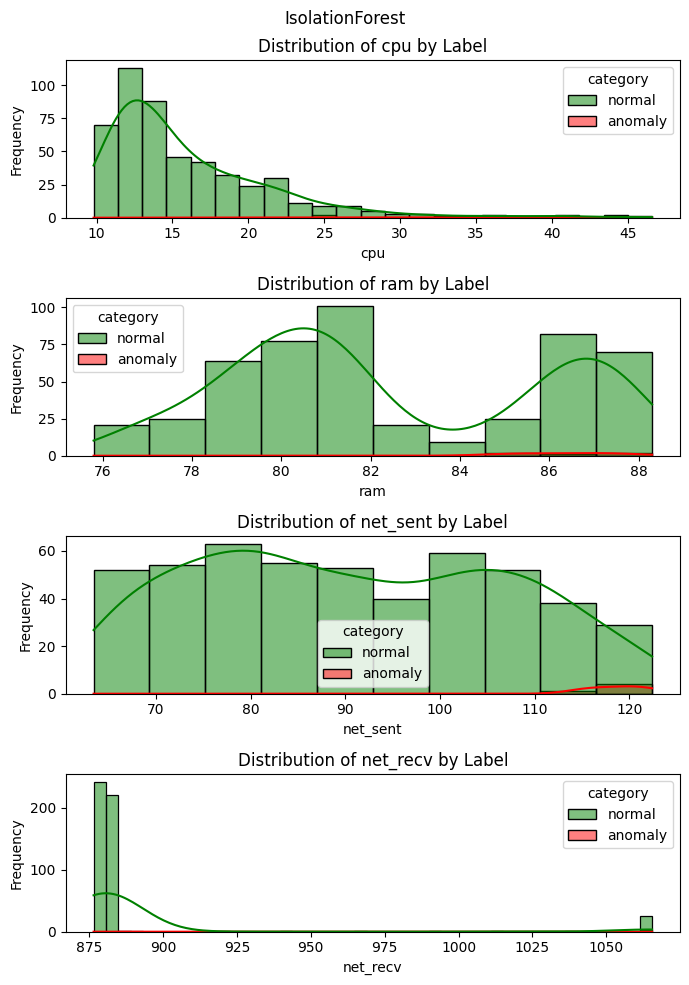

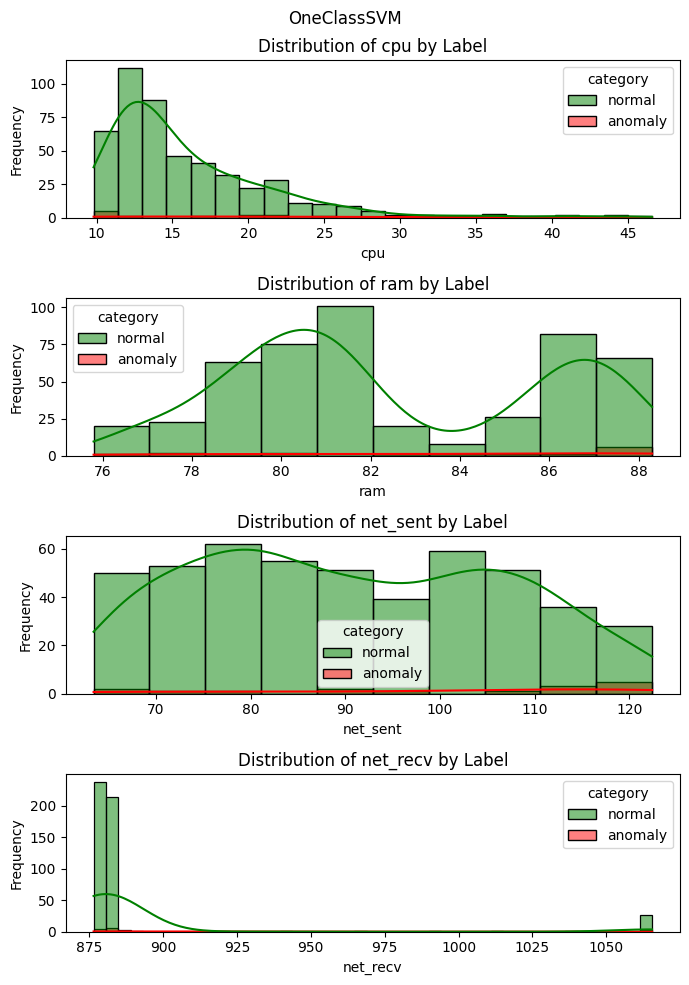

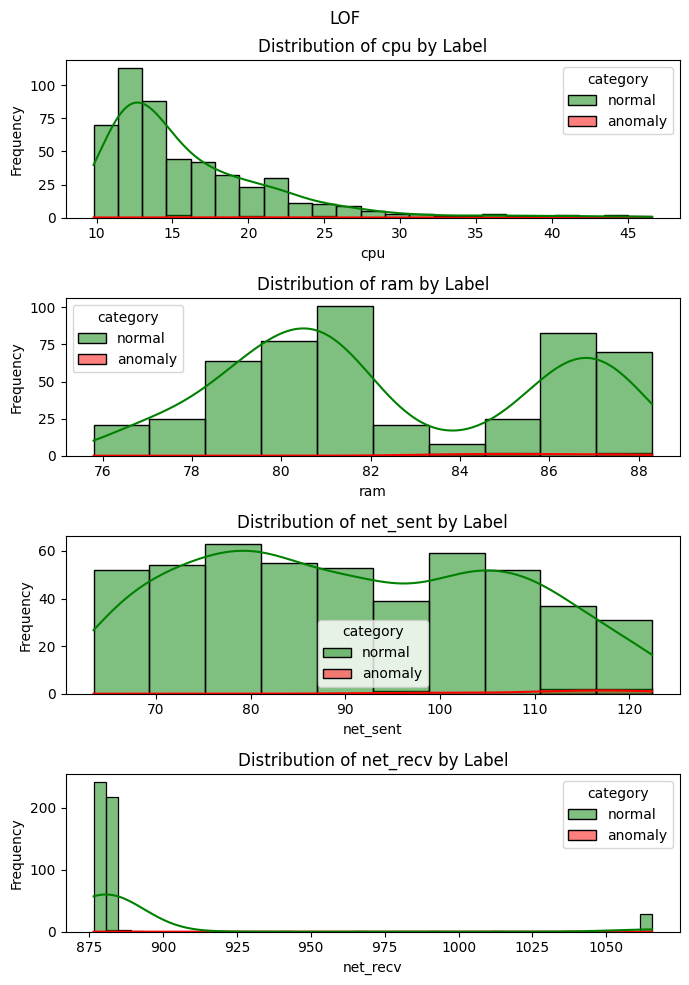

In [13]:
for model_result in result_data_all:
    numerical_cols = model_result["evaluation_data"].select_dtypes(include=np.number).columns

    plt.figure(figsize=(7, 10))
    for i, col in enumerate(numerical_cols):
        plt.subplot(len(numerical_cols), 1, i + 1)
        sns.histplot(data=model_result["evaluation_data"], x=col, hue='category', palette={'anomaly': 'red', 'normal': 'green'}, kde=True) # Use hue for coloring by label and palette to set specific colors
        plt.title(f'Distribution of {col} by Label')
        plt.tight_layout()
        plt.xlabel(col)
        plt.suptitle(f"{model_result["model_name"]}")
        plt.ylabel('Frequency' if df[col].dtype != 'object' else 'Count')

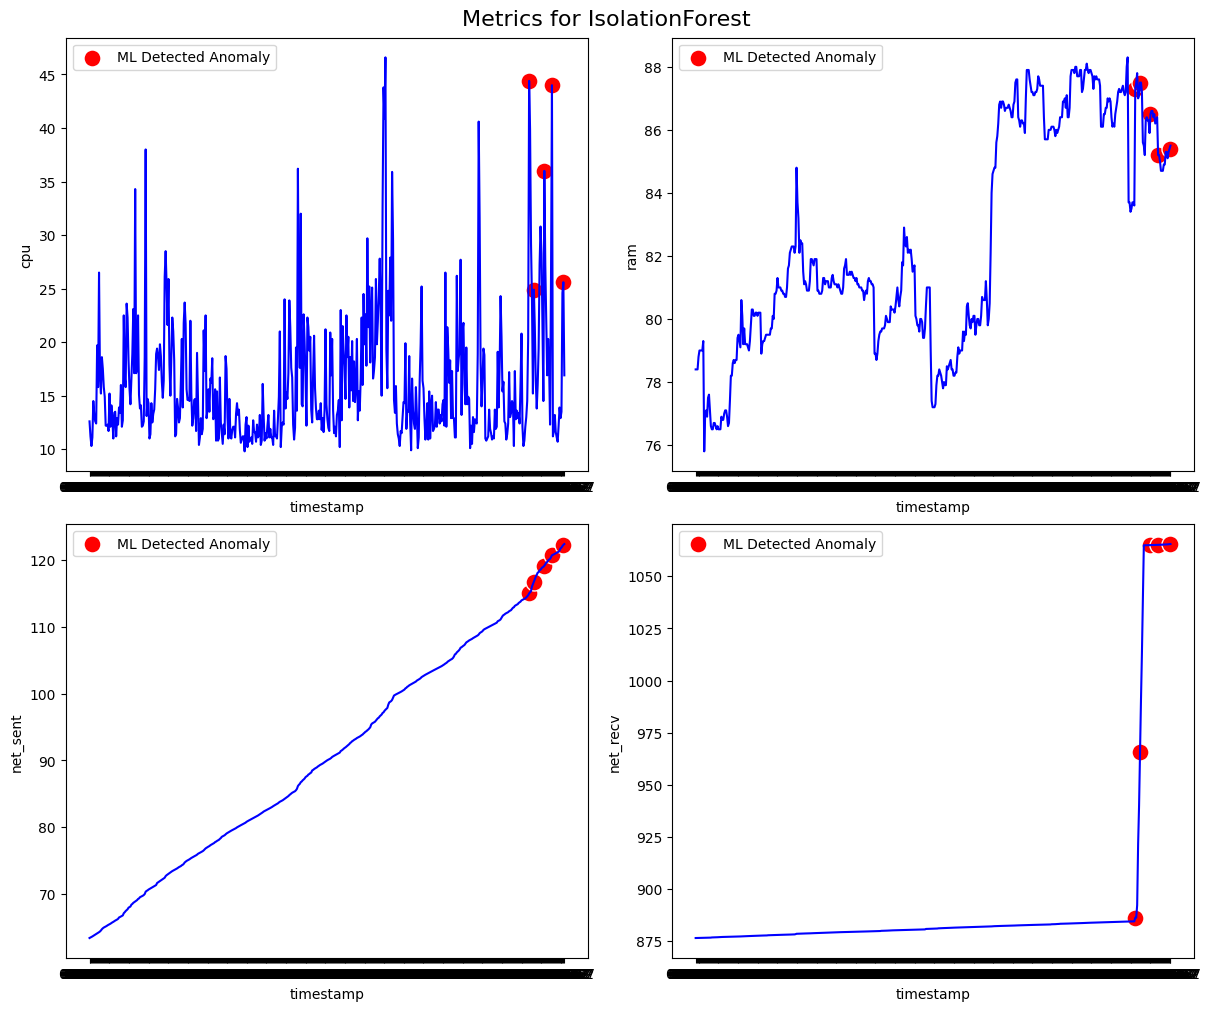

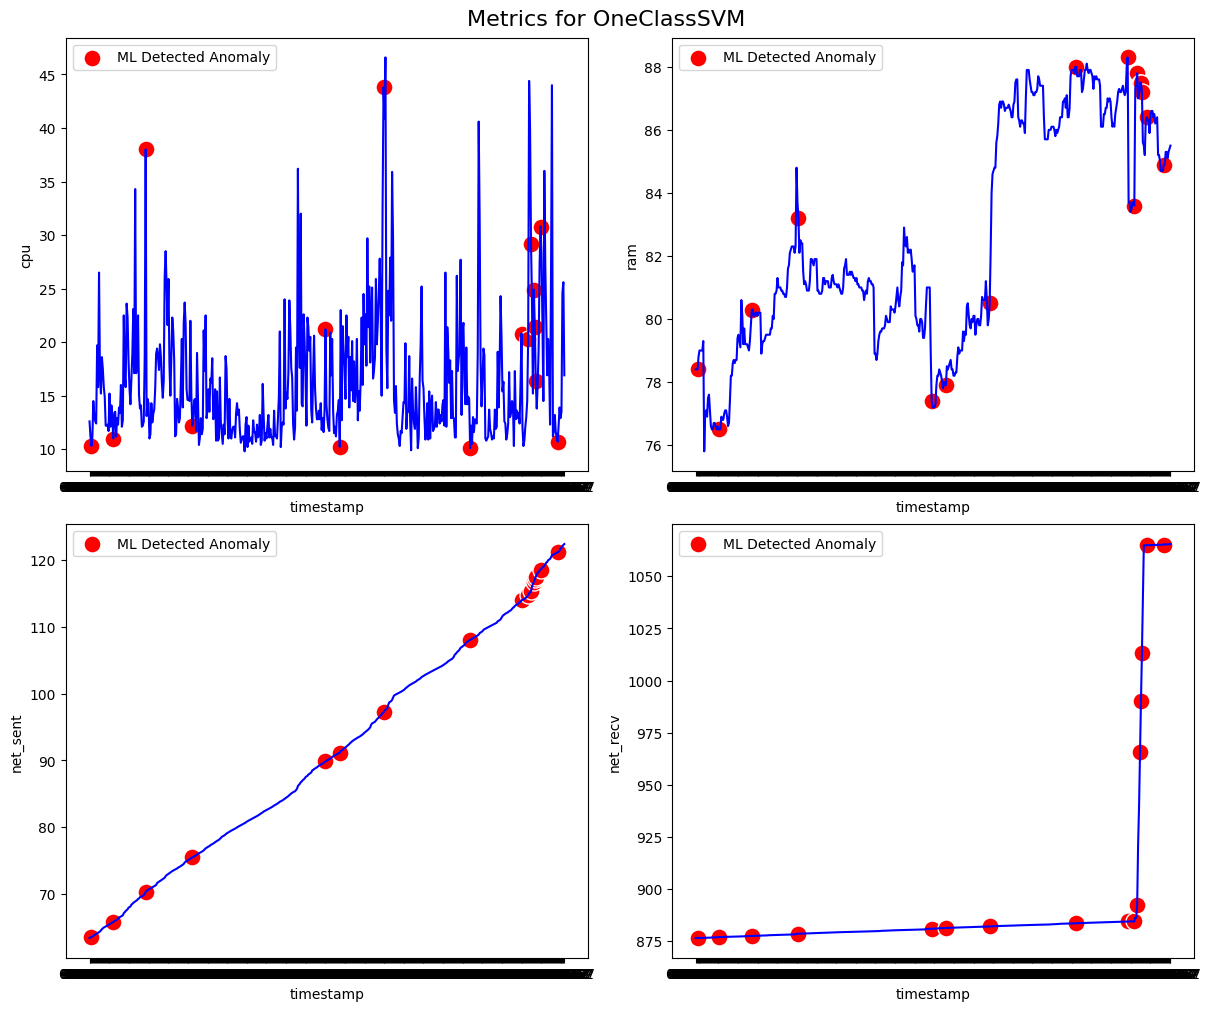

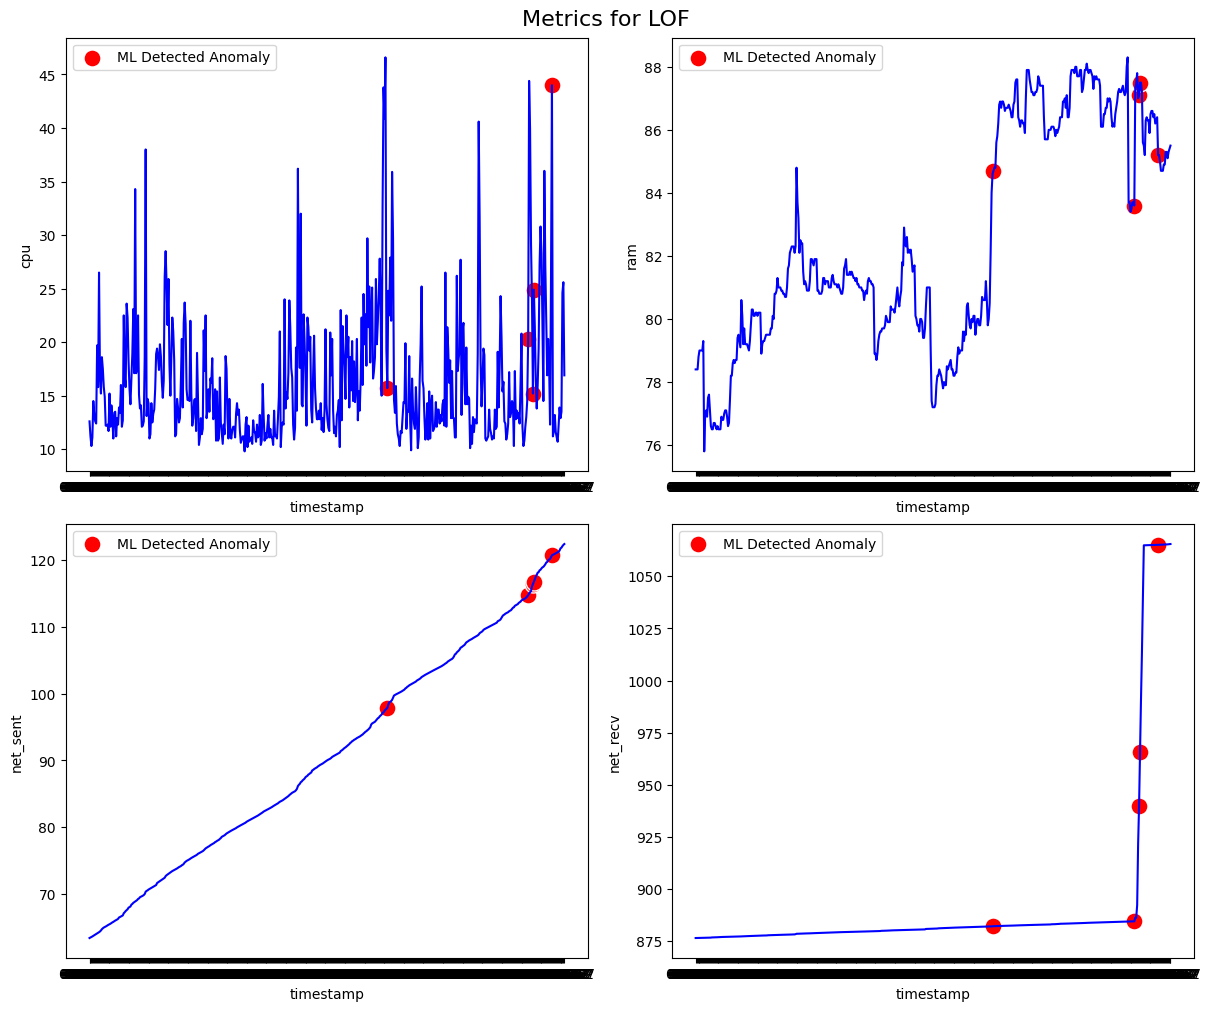

In [14]:
for model_result in result_data_all:
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, figure=fig) # Define a 2x2 grid for the current figure
    fig.suptitle(f'Metrics for {model_result["model_name"]}', fontsize=16)
    ax_list = [fig.add_subplot(gs[i, j]) for i in range (2) for j in range (2)]
    for ax, metric in zip(ax_list, X.columns):
        # sns.lineplot(x=df["timestamp"], y=df[metric], hue=model_result["evaluation_data"]["category"], palette={'anomaly': 'red', 'normal': 'green'}, data=df, ax=ax)
        sns.lineplot(x=df["timestamp"], y=df[metric], color="blue", data=df, ax=ax)
        sns.scatterplot(x=df["timestamp"], y=df[model_result["evaluation_data"]["category"] == "anomaly"][metric], color='red', s=150, label='ML Detected Anomaly', data=df, ax=ax)
    plt.show()

In [36]:
result_data_all[2]

{'model_name': 'LOF',
 'evaluation_data':       cpu   ram    net_sent     net_recv category
 0    12.6  78.4   63.401973   876.555230   normal
 1    11.2  78.4   63.478015   876.567491   normal
 2    10.3  78.4   63.563416   876.589496   normal
 3    11.1  78.8   63.639262   876.600947   normal
 4    14.5  79.0   63.729137   876.615638   normal
 ..    ...   ...         ...          ...      ...
 495  12.9  85.3  121.773097  1065.243807   normal
 496  13.5  85.1  121.880112  1065.282935   normal
 497  24.6  85.3  122.108528  1065.325688   normal
 498  25.6  85.4  122.290592  1065.394284   normal
 499  16.9  85.5  122.423190  1065.445098   normal
 
 [500 rows x 5 columns]}

Axes(0.125,0.653529;0.775x0.226471)-->IsolationForest
Axes(0.125,0.653529;0.775x0.226471)-->cpu
Axes(0.125,0.653529;0.775x0.226471)-->ram
Axes(0.125,0.653529;0.775x0.226471)-->net_sent
Axes(0.125,0.653529;0.775x0.226471)-->net_recv
Axes(0.125,0.381765;0.775x0.226471)-->OneClassSVM
Axes(0.125,0.381765;0.775x0.226471)-->cpu
Axes(0.125,0.381765;0.775x0.226471)-->ram
Axes(0.125,0.381765;0.775x0.226471)-->net_sent
Axes(0.125,0.381765;0.775x0.226471)-->net_recv
Axes(0.125,0.11;0.775x0.226471)-->LOF
Axes(0.125,0.11;0.775x0.226471)-->cpu
Axes(0.125,0.11;0.775x0.226471)-->ram
Axes(0.125,0.11;0.775x0.226471)-->net_sent
Axes(0.125,0.11;0.775x0.226471)-->net_recv


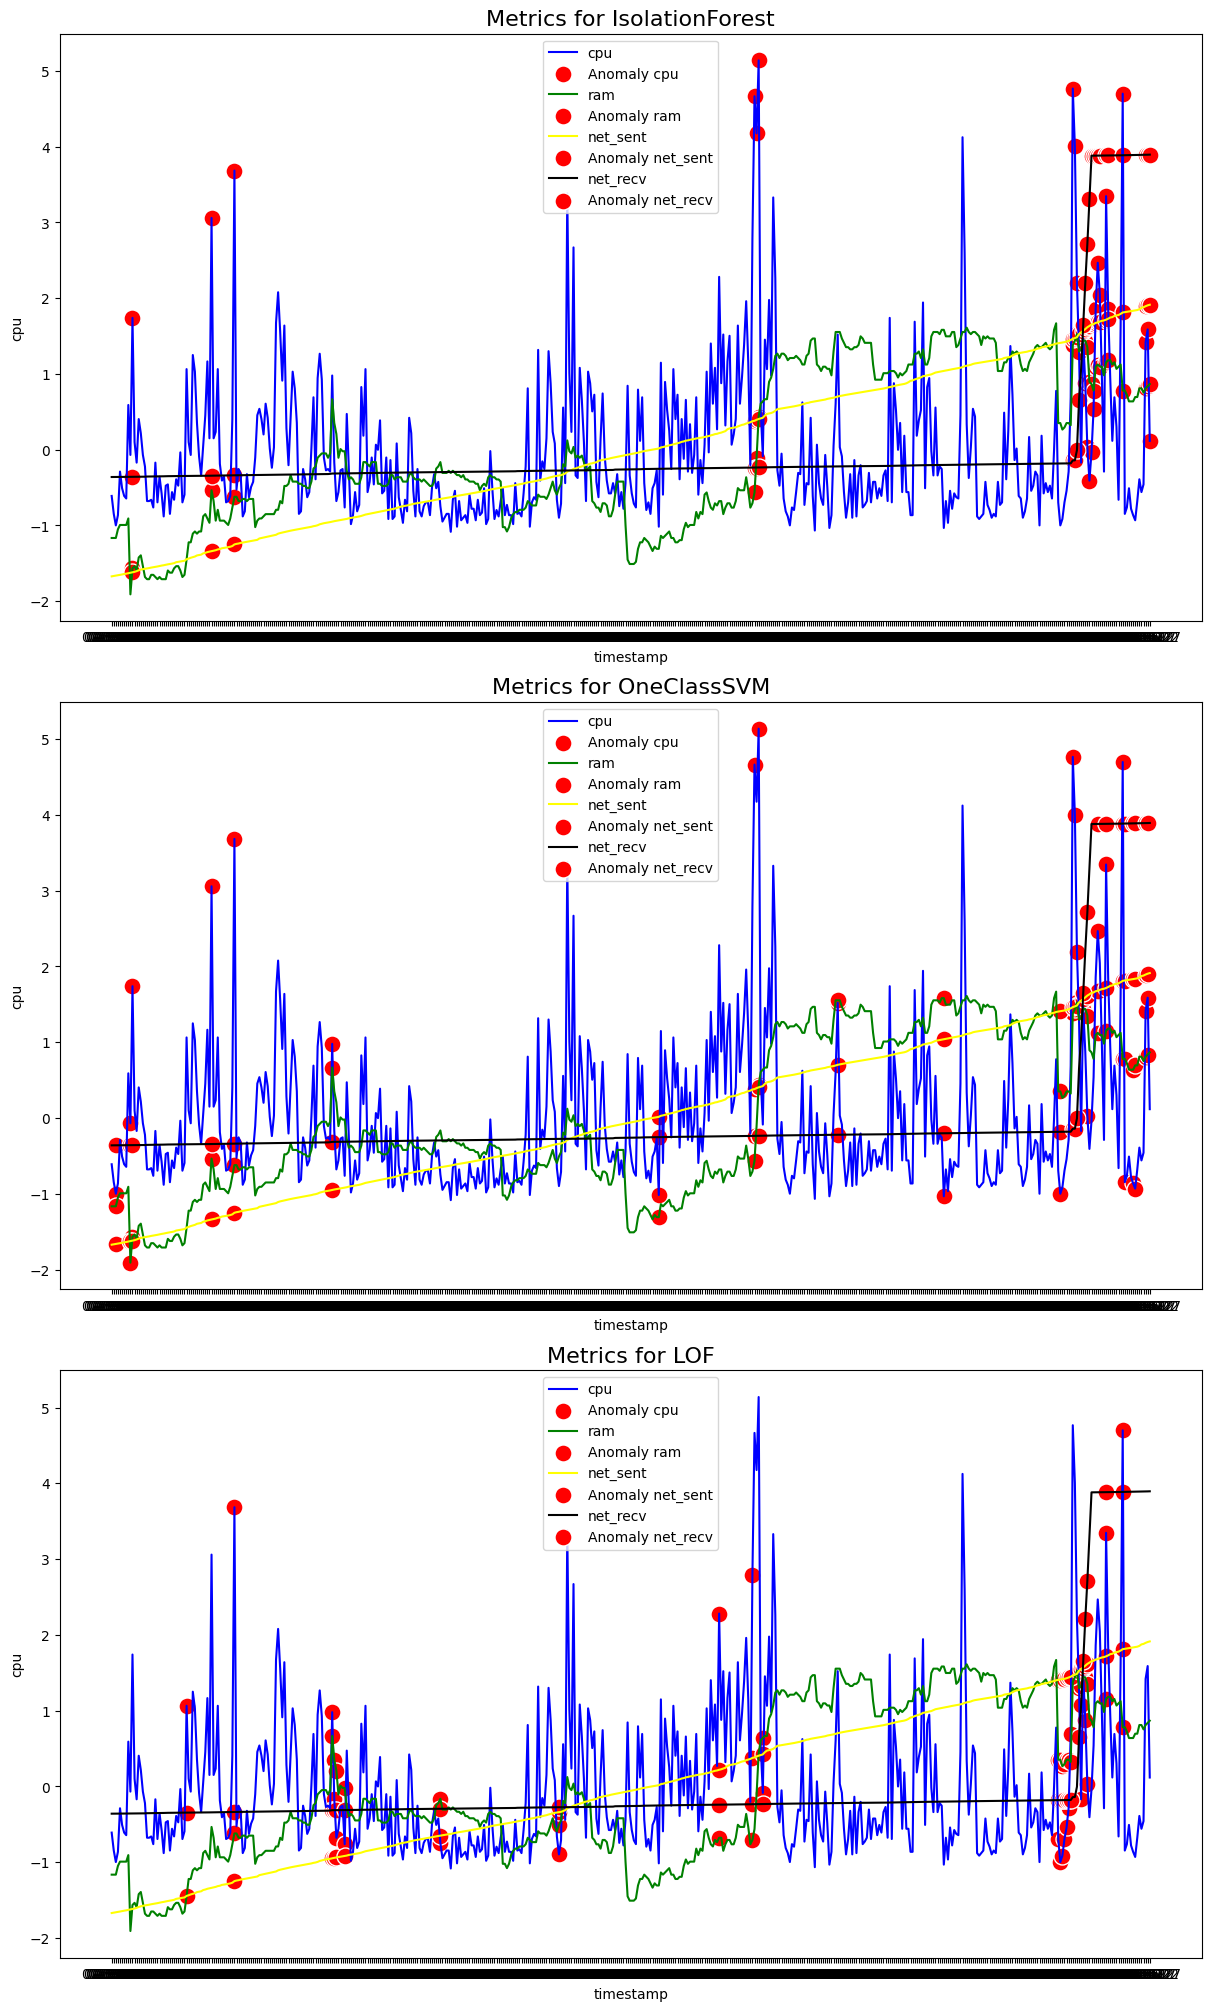

In [37]:
fig = plt.figure(figsize=(12, 20), constrained_layout=True)
gs = gridspec.GridSpec(3, 1, figure=fig) # Define a 2x2 grid for the current figure
ax_list = [fig.add_subplot(gs[i, j]) for i in range (3) for j in range (1)]
for model_result, ax in zip(result_data_all, ax_list):
    print(f"{ax}-->{model_result["model_name"]}")
    ax.set_title(f'Metrics for {model_result["model_name"]}', fontsize=16)
    for color, metric in zip(["blue","green","yellow","black"],X.columns):
        print(f"{ax}-->{metric}")
        df_plot = pd.concat([df["timestamp"],pd.DataFrame(X_scaled, columns=X.columns)],axis=1)
        sns.lineplot(x=df_plot["timestamp"], y=df_plot[metric], color=color, ax=ax, label=f'{metric}')
        sns.scatterplot(x=df_plot["timestamp"], y=df_plot[model_result["evaluation_data"]["category"] == "anomaly"][metric], color='red', s=150, label=f'Anomaly {metric}', ax=ax)
plt.show()

In [7]:
np.arange(0.05, 0.12, 0.01)

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11])

IsolationForest → Detected 25 anomalies out of 500
OneClassSVM → Detected 25 anomalies out of 500
LOF → Detected 25 anomalies out of 500
======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===============IsolationForest===============
-------------------normal--------------------
              cpu         ram    net_sent     net_recv
count  475.000000  475.000000  475.000000   475.000000
mean    15.505053   82.336421   89.933374   887.774853
std      4.689693    3.480991   15.837739    35.408639
min      9.800000  

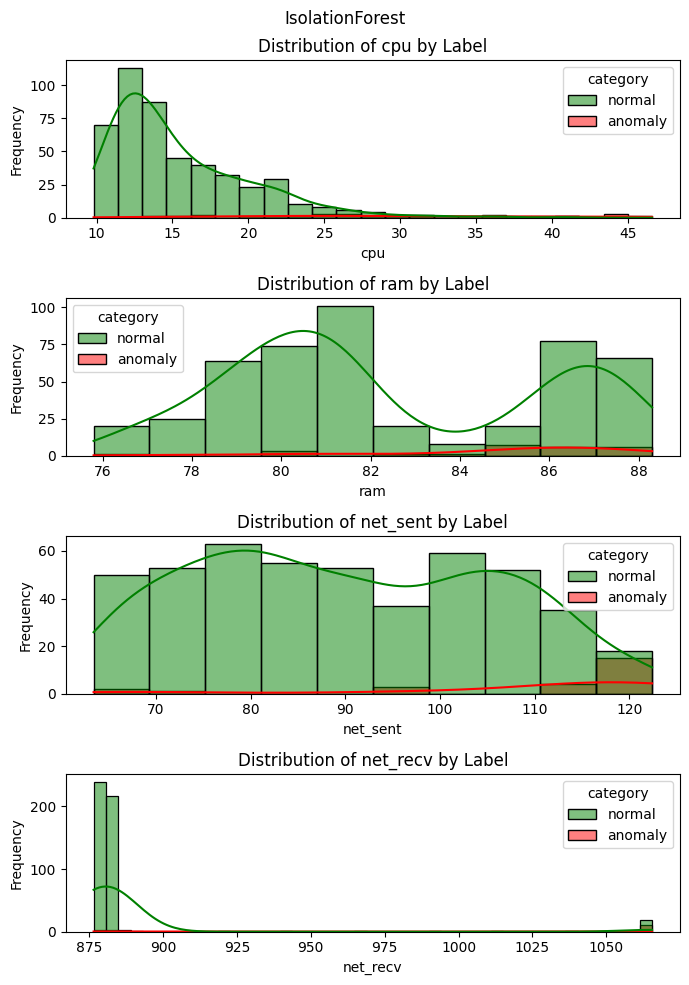

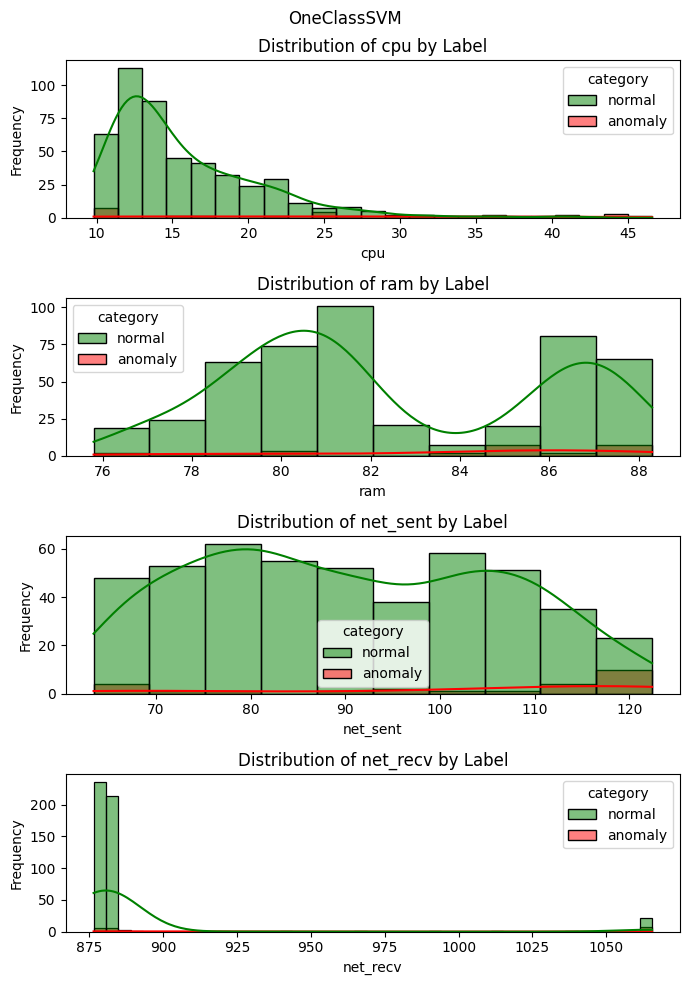

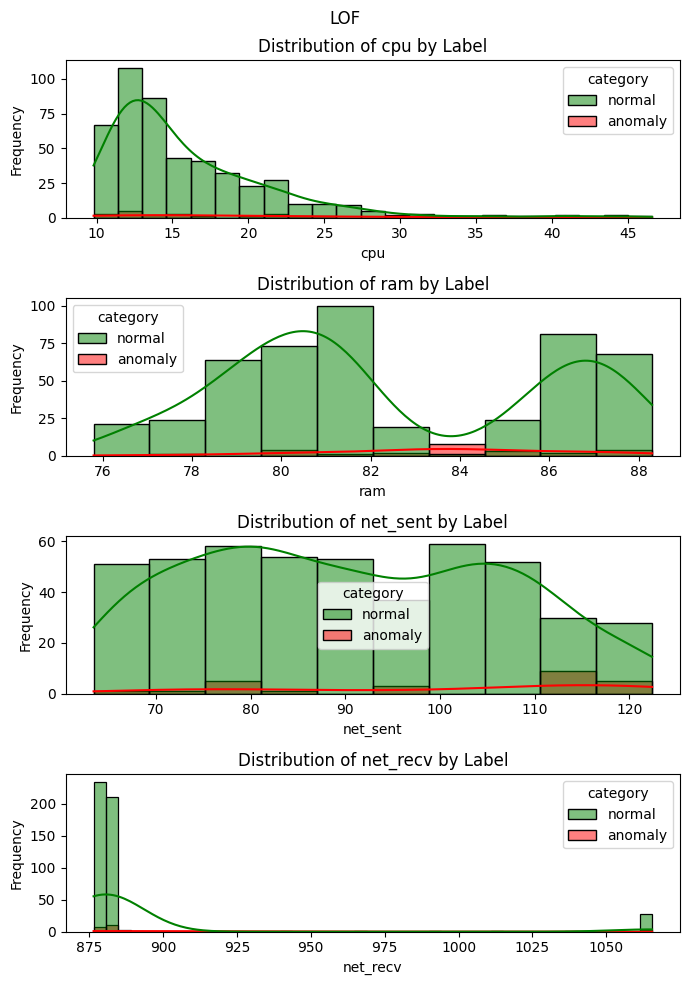

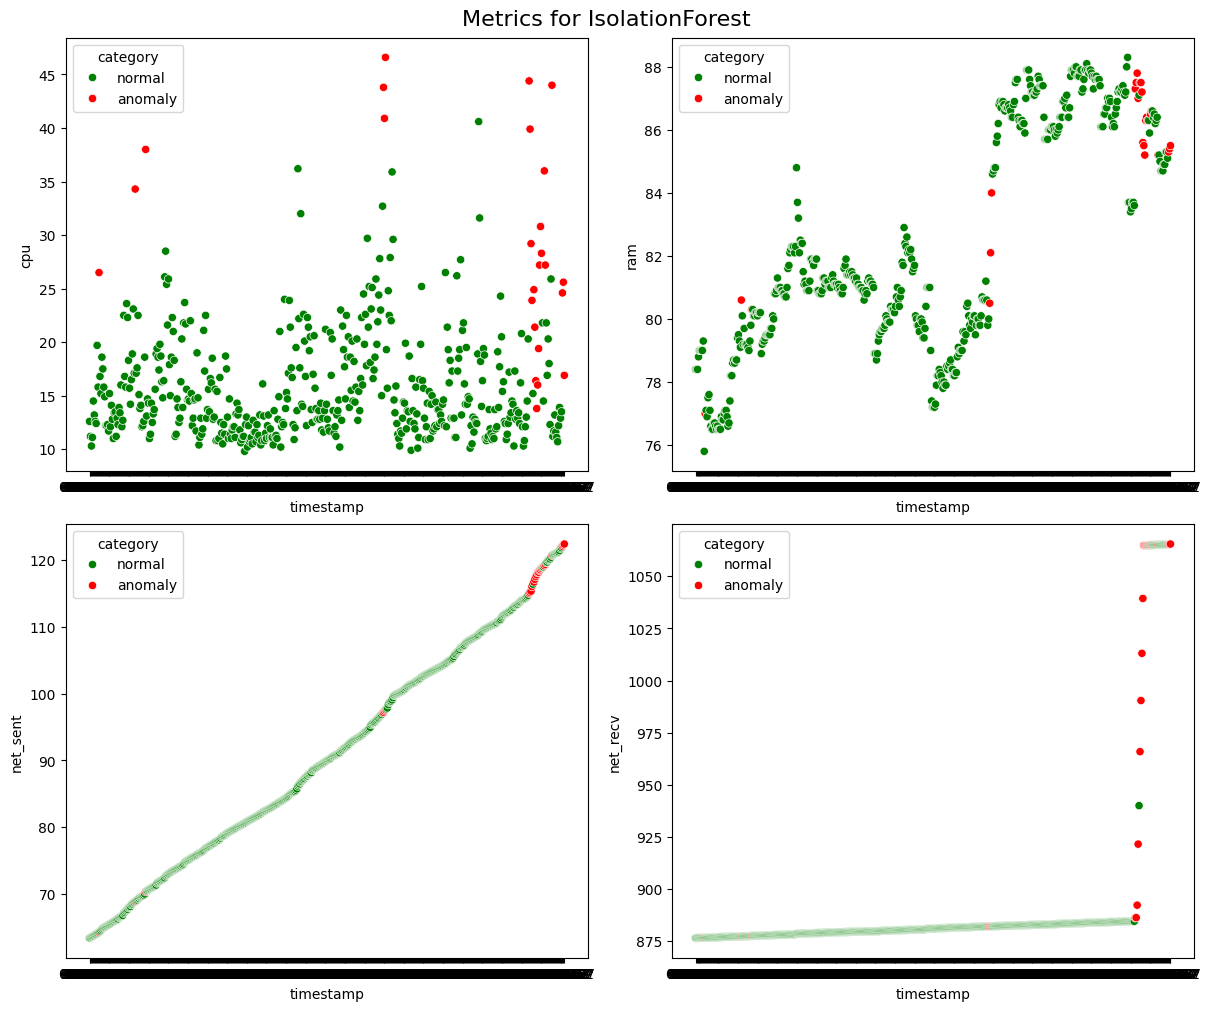

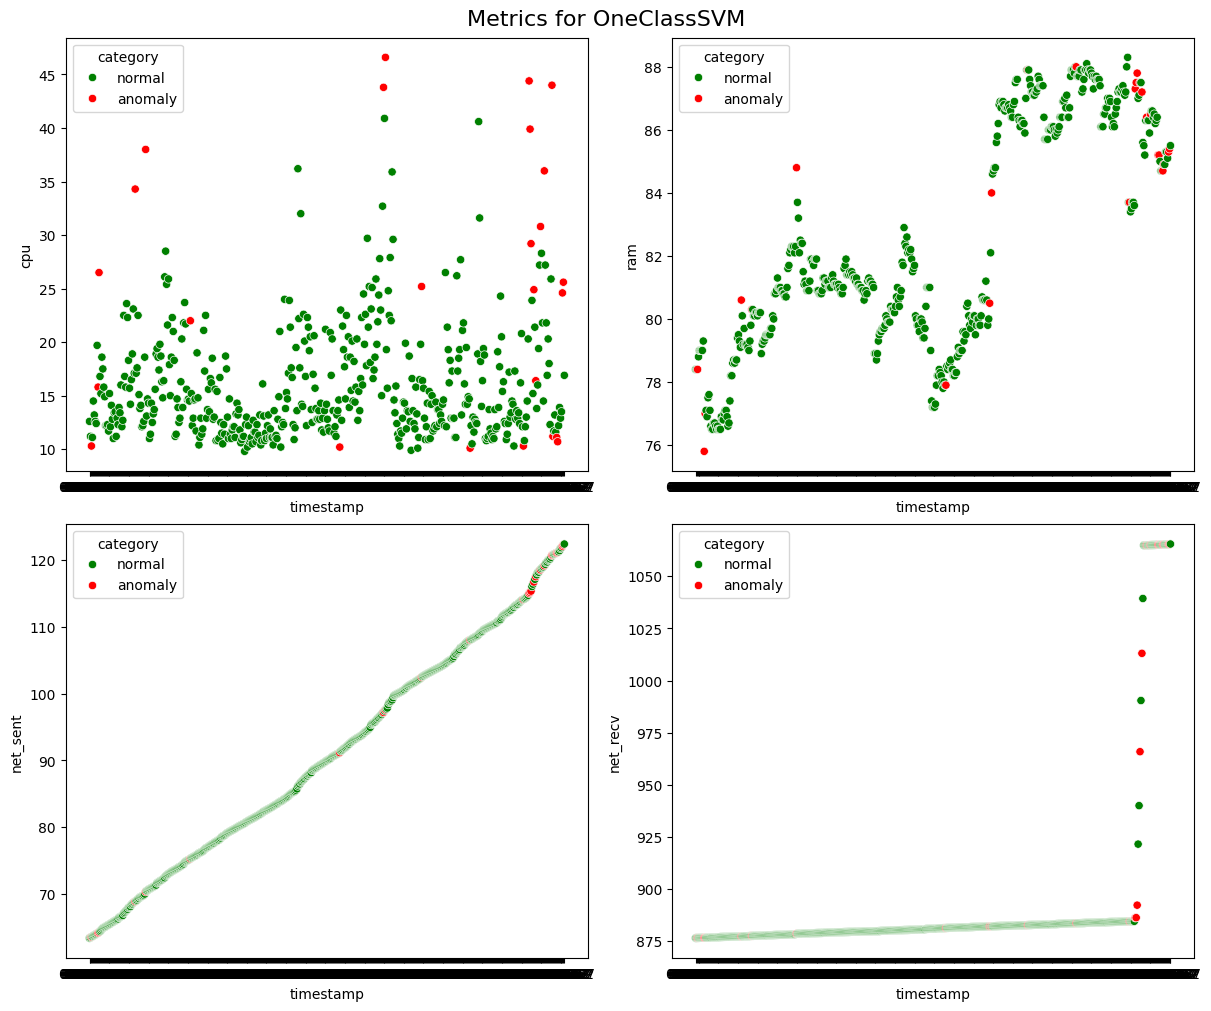

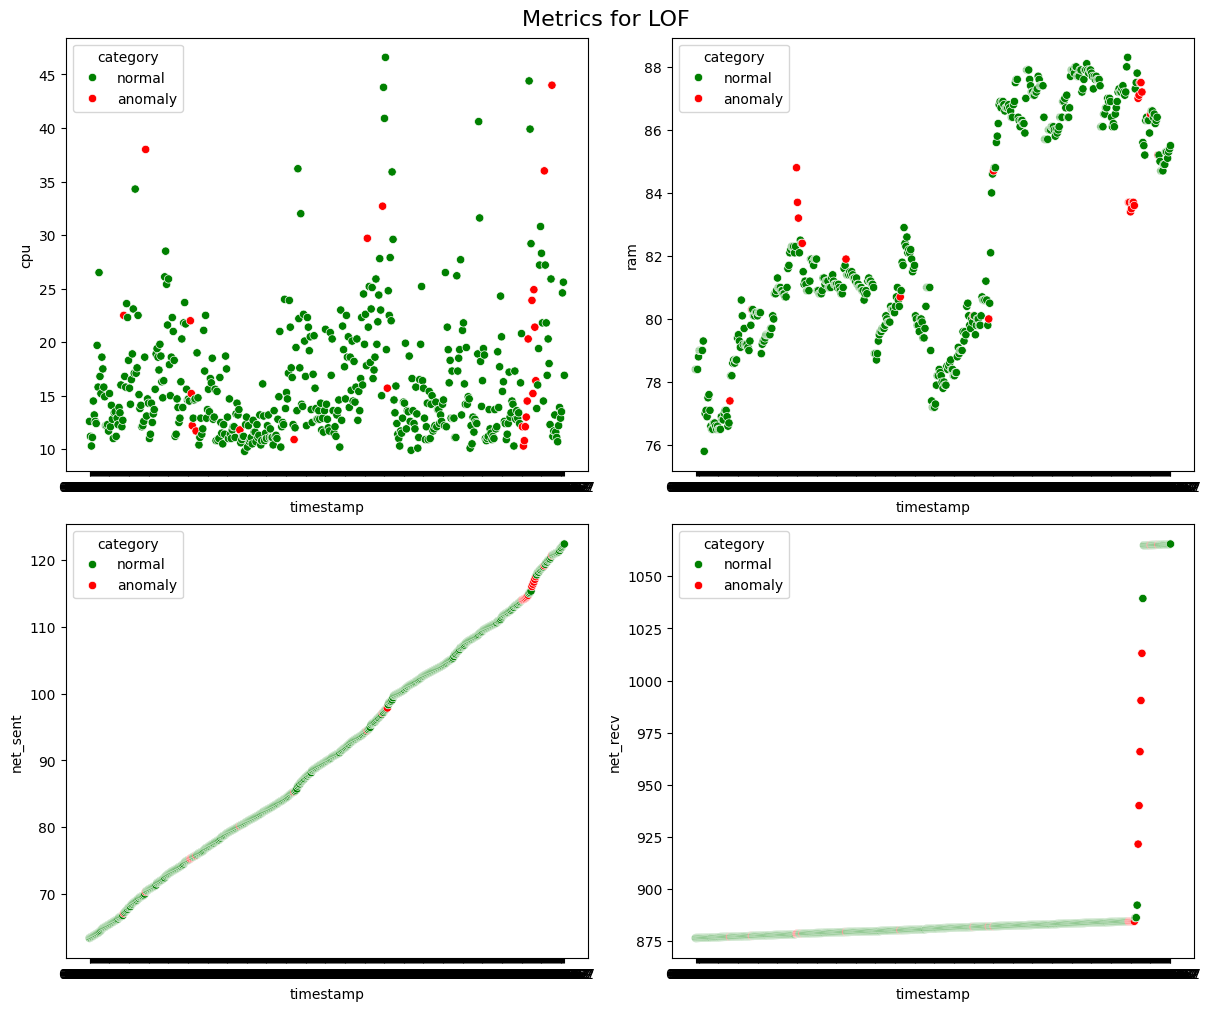

IsolationForest → Detected 30 anomalies out of 500
OneClassSVM → Detected 31 anomalies out of 500
LOF → Detected 30 anomalies out of 500
======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===============IsolationForest===============
-------------------normal--------------------
              cpu         ram    net_sent     net_recv
count  470.000000  470.000000  470.000000   470.000000
mean    15.395532   82.299574   89.713528   886.933347
std      4.437089    3.476053   15.719821    33.561424
min      9.800000  

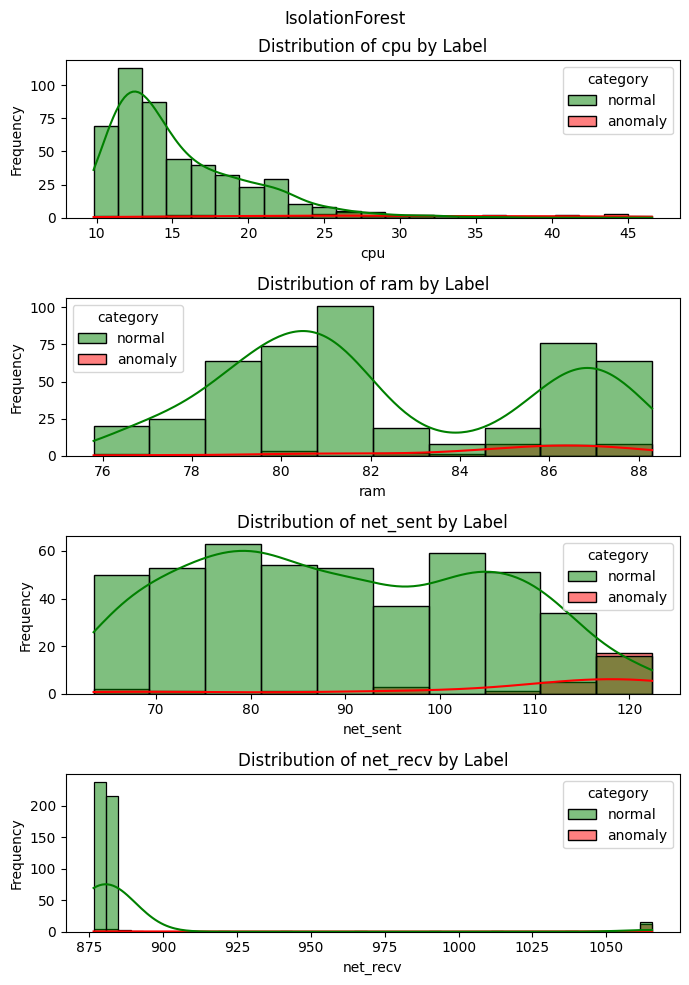

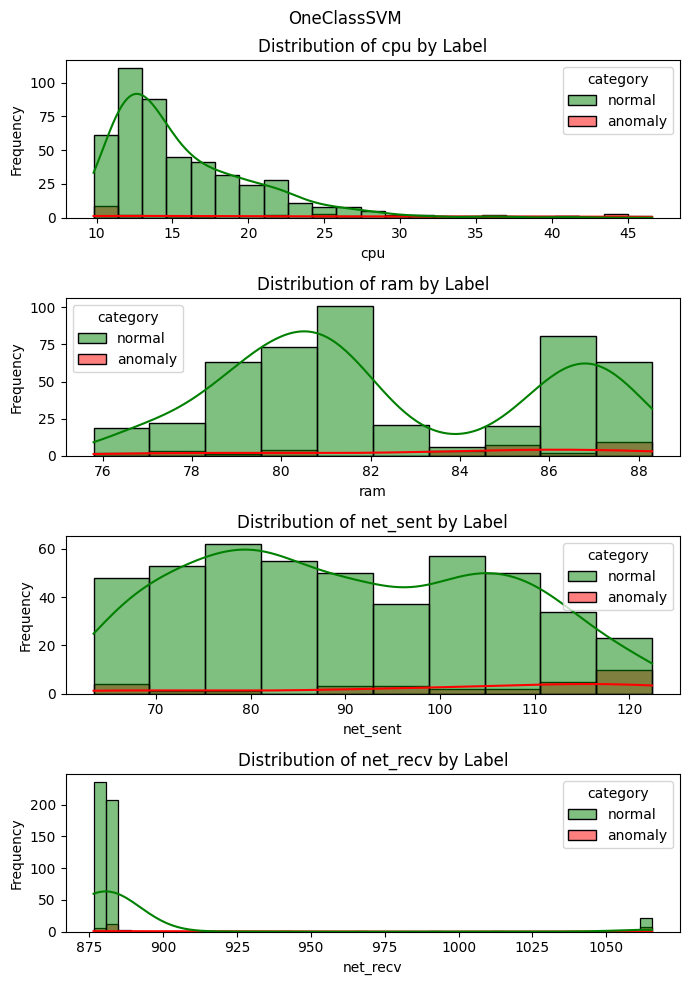

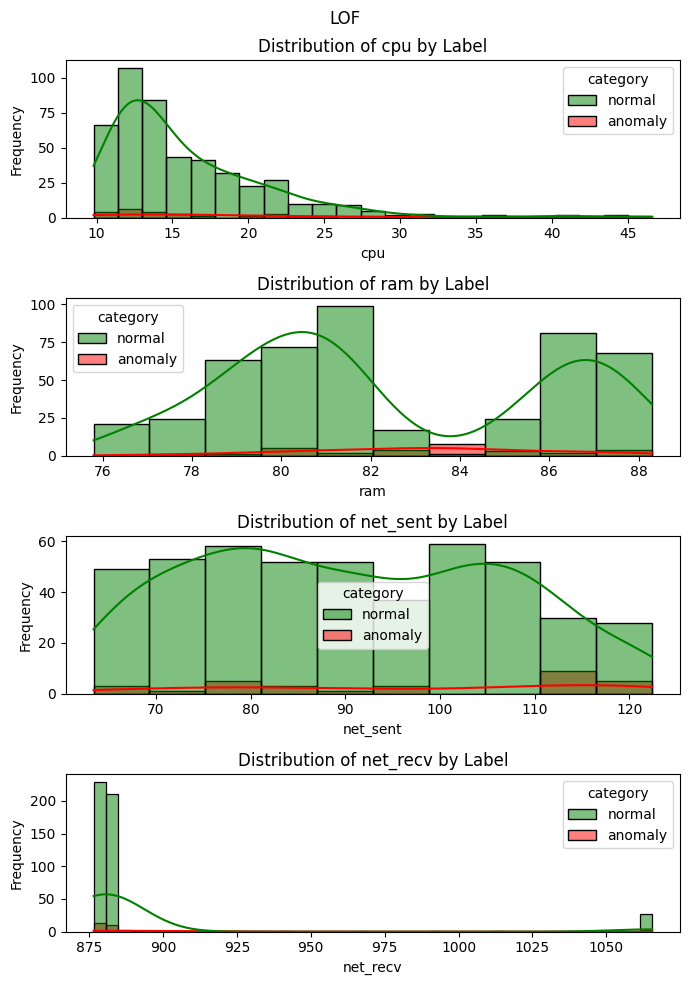

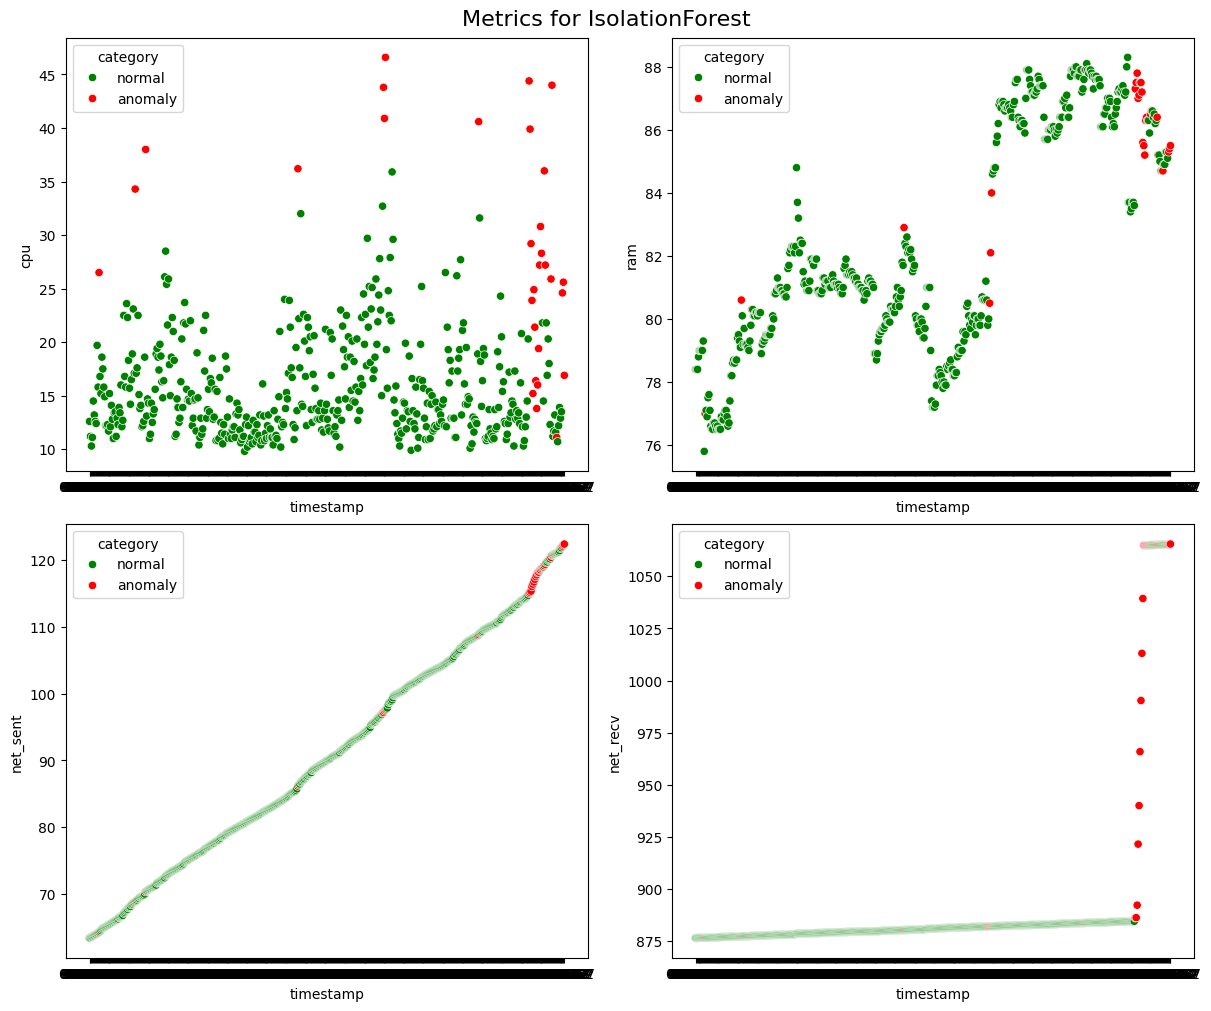

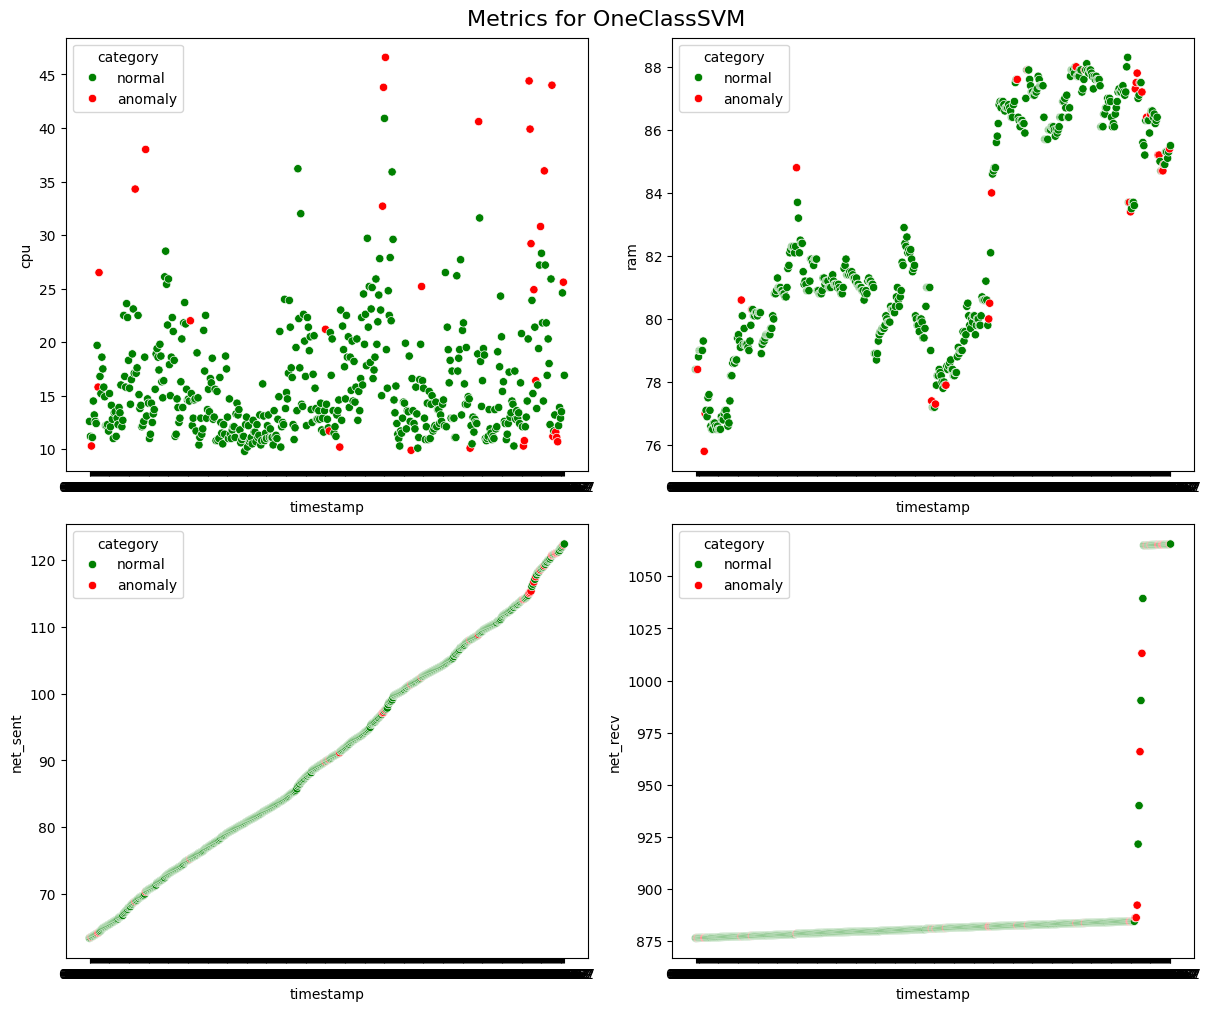

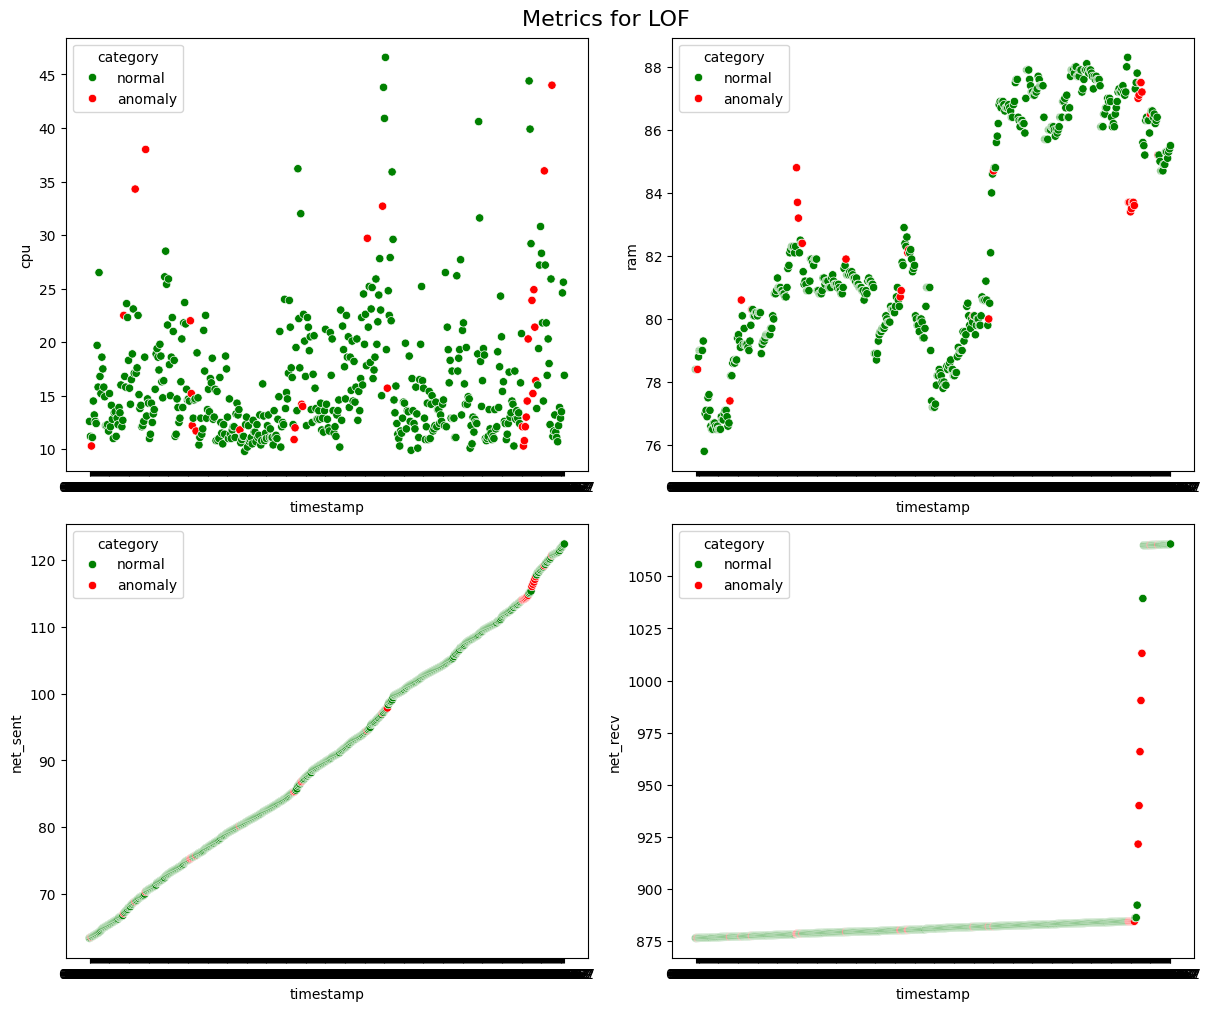

IsolationForest → Detected 35 anomalies out of 500
OneClassSVM → Detected 37 anomalies out of 500
LOF → Detected 35 anomalies out of 500
======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===============IsolationForest===============
-------------------normal--------------------
              cpu         ram    net_sent     net_recv
count  465.000000  465.000000  465.000000   465.000000
mean    15.429247   82.269032   89.376532   885.017006
std      4.447632    3.481581   15.462024    28.152453
min      9.800000  

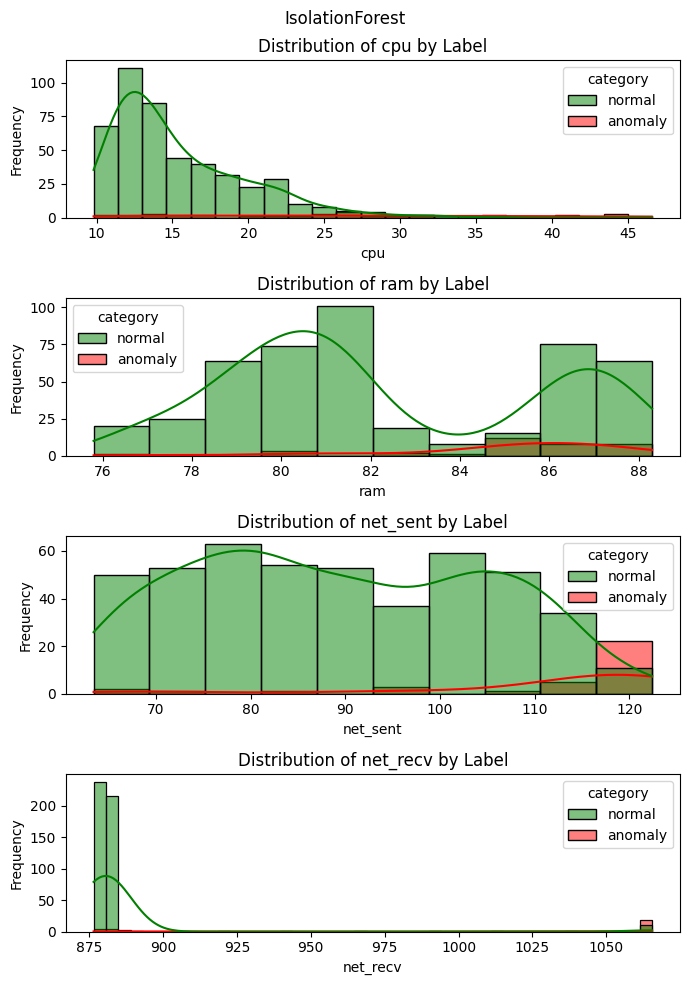

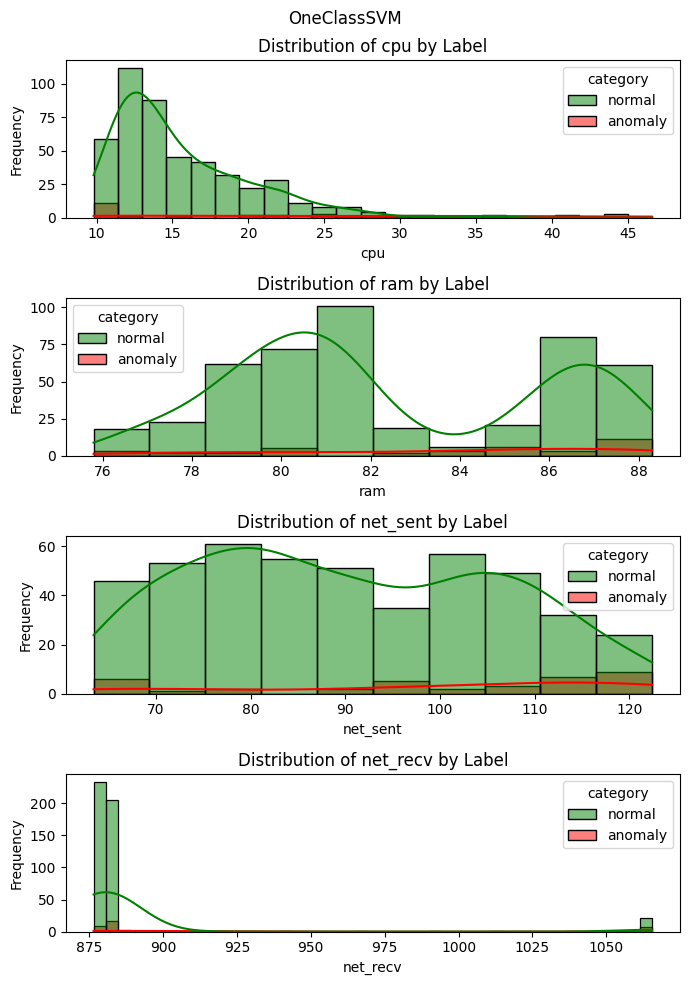

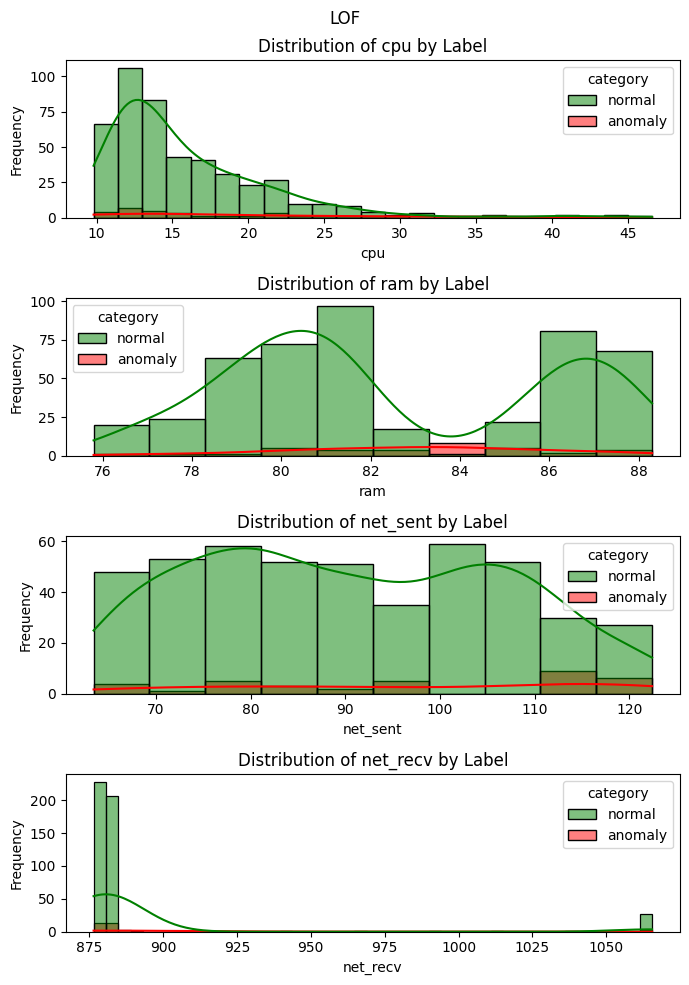

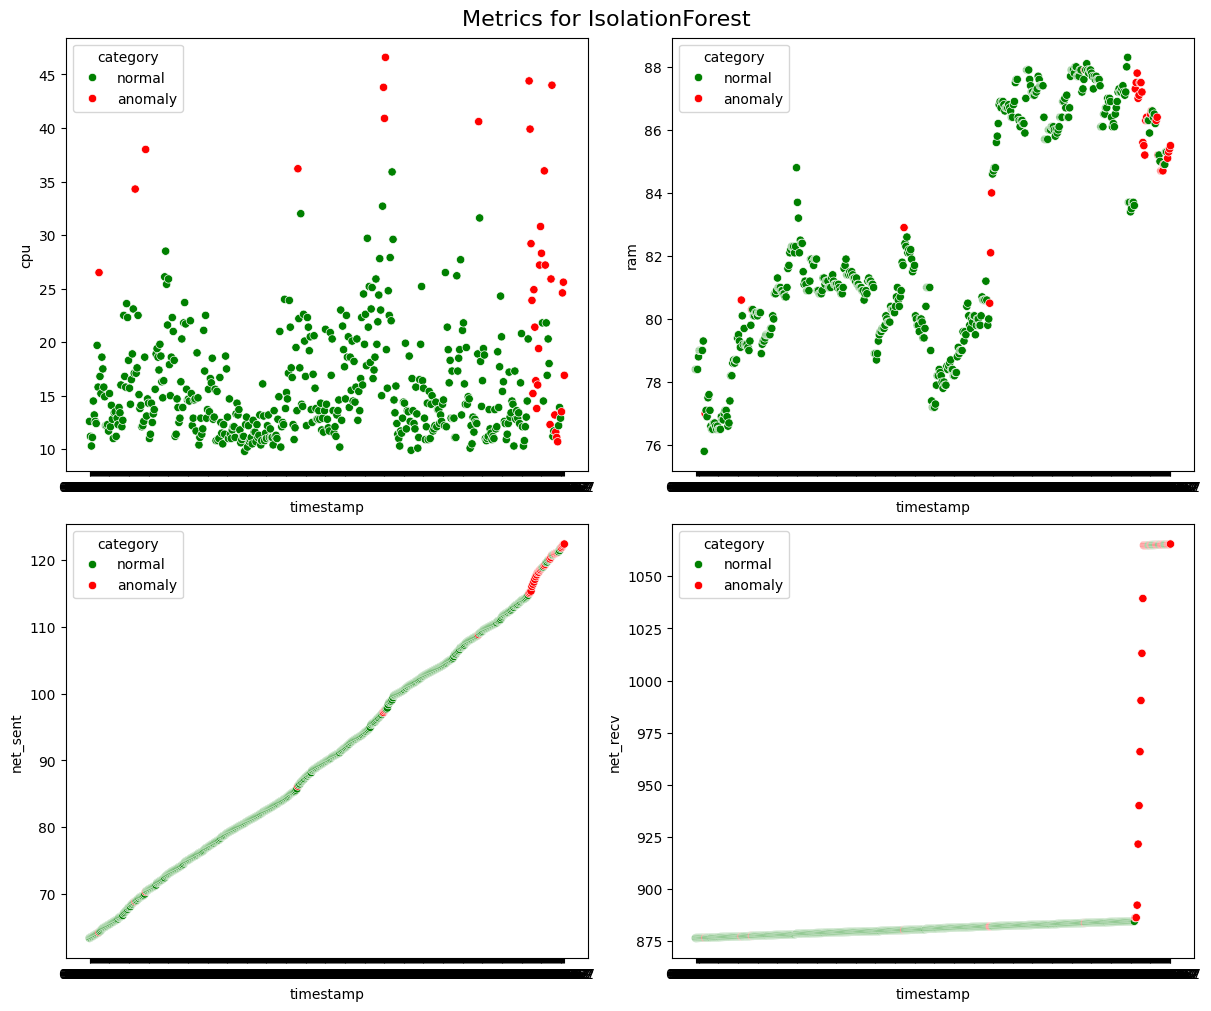

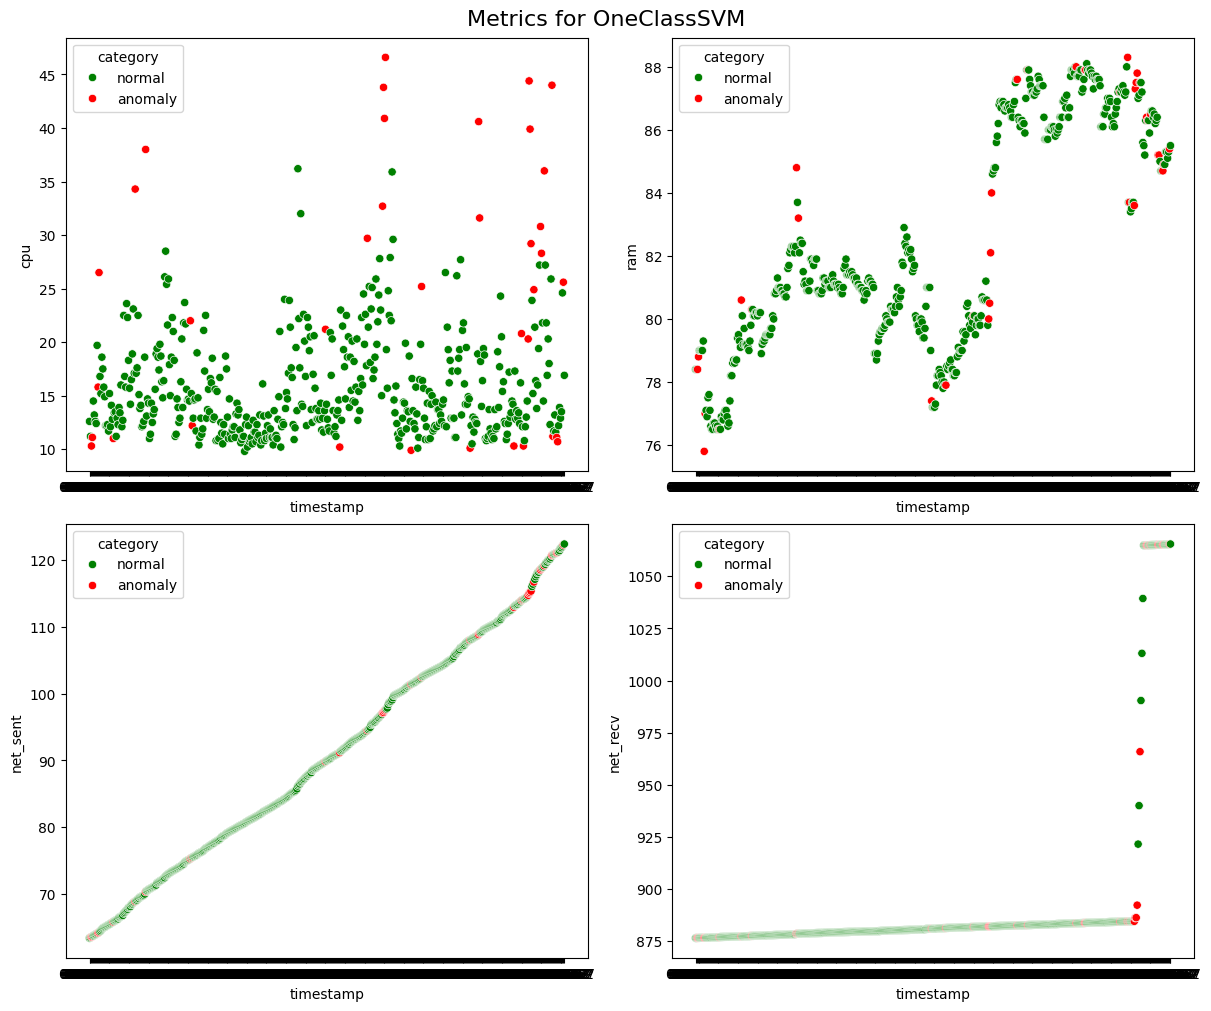

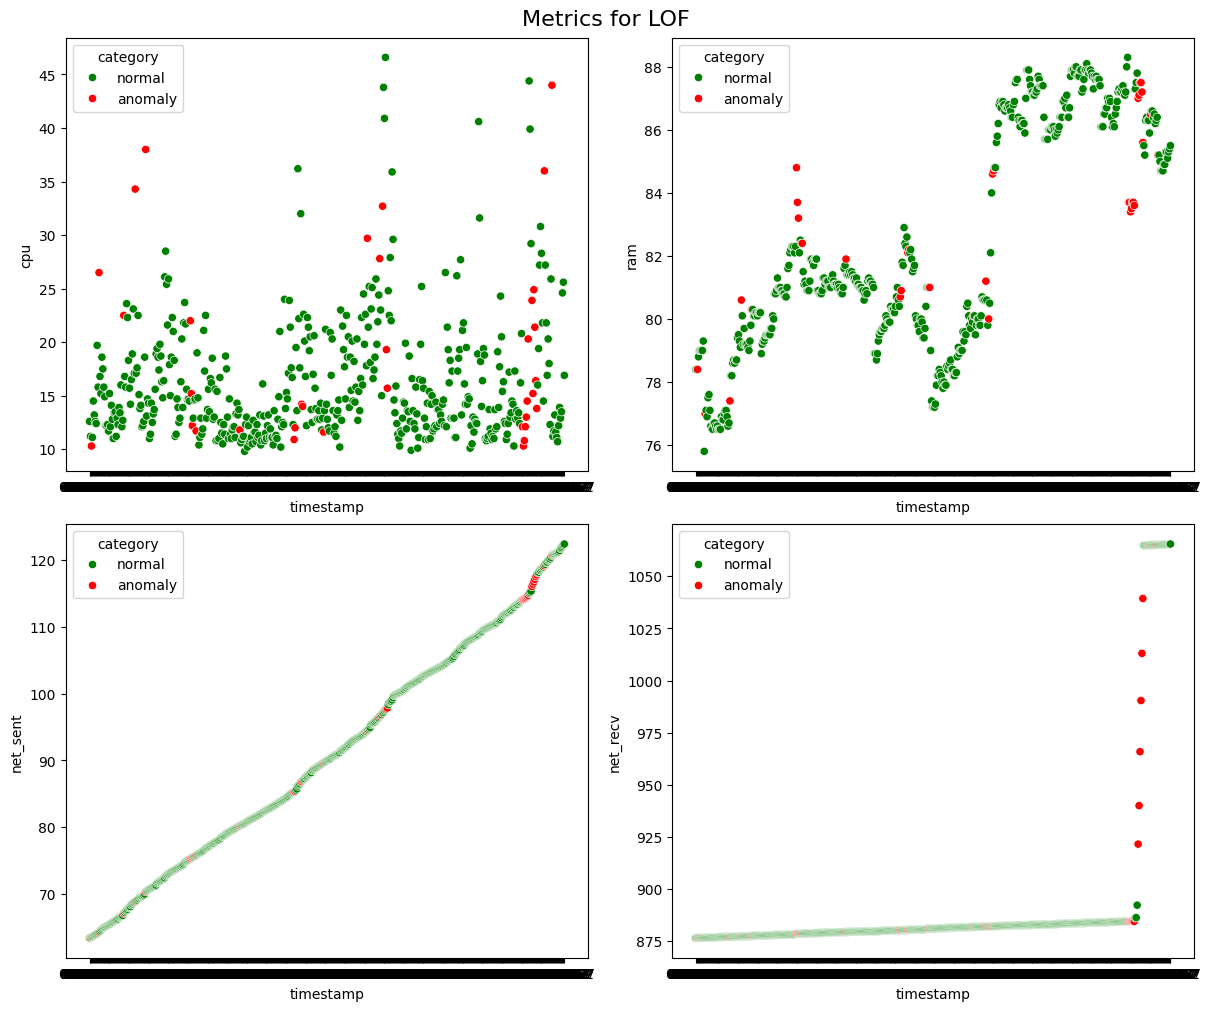

IsolationForest → Detected 40 anomalies out of 500
OneClassSVM → Detected 41 anomalies out of 500
LOF → Detected 40 anomalies out of 500
======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===============IsolationForest===============
-------------------normal--------------------
              cpu         ram    net_sent     net_recv
count  460.000000  460.000000  460.000000   460.000000
mean    15.449783   82.233478   89.038015   883.059665
std      4.462541    3.483170   15.198254    21.074101
min      9.800000  

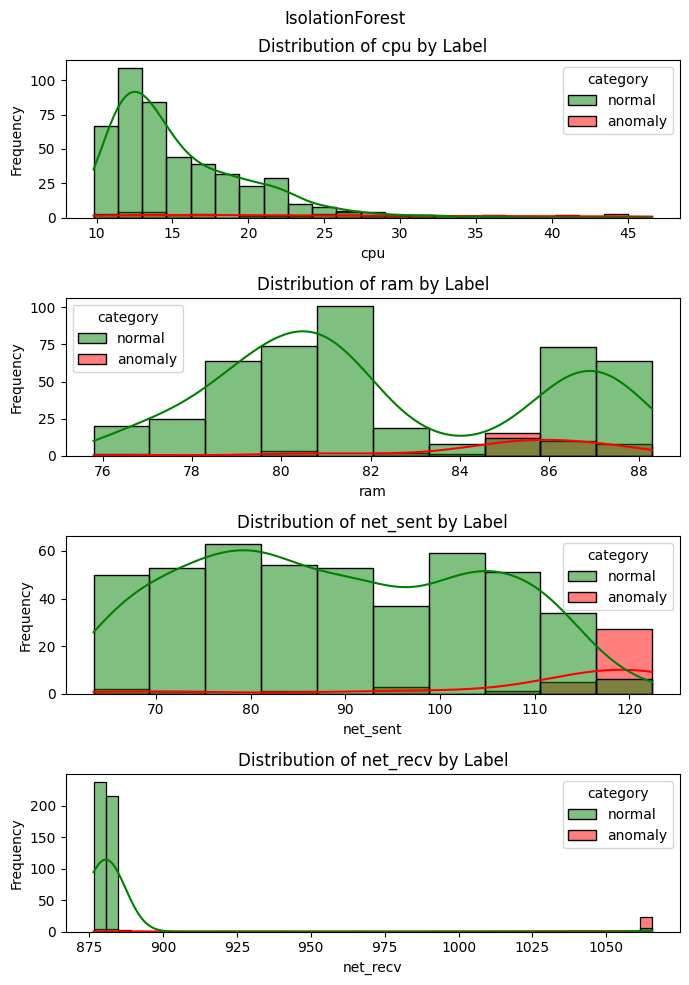

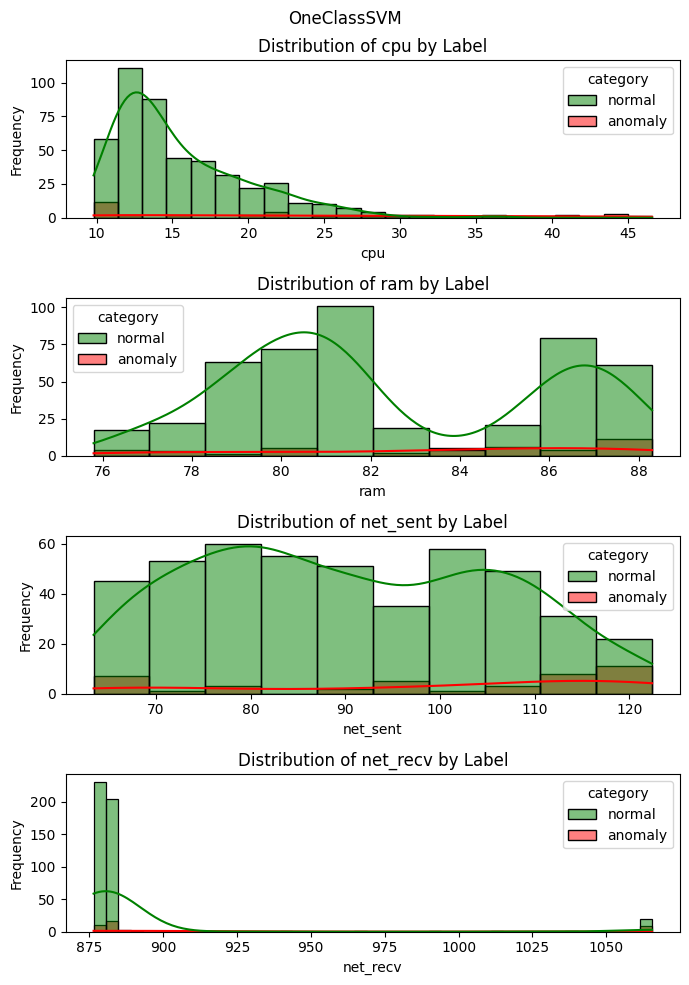

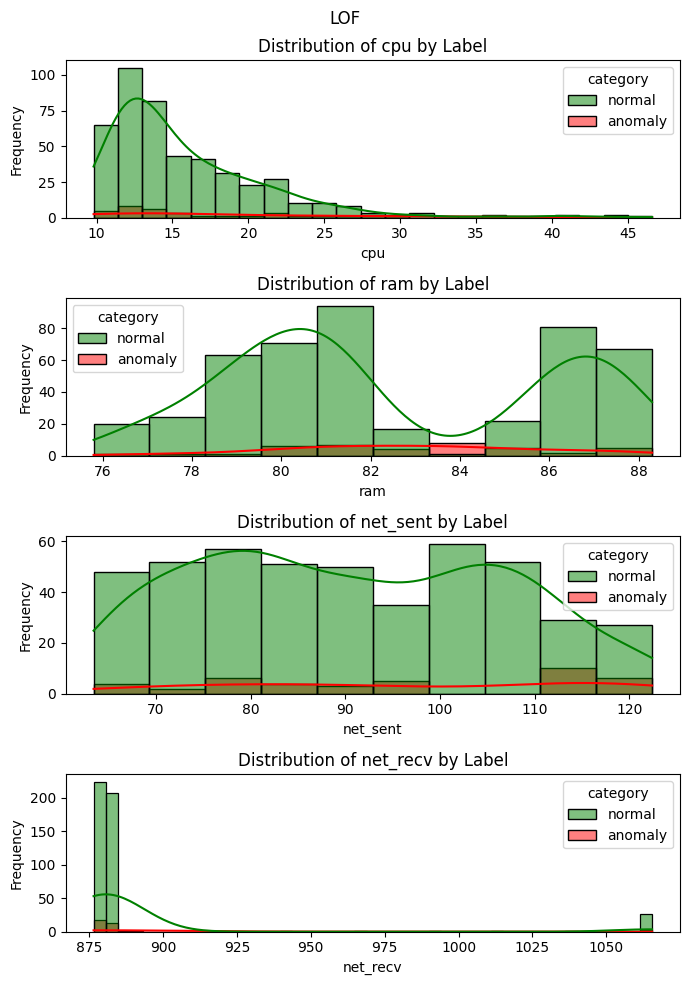

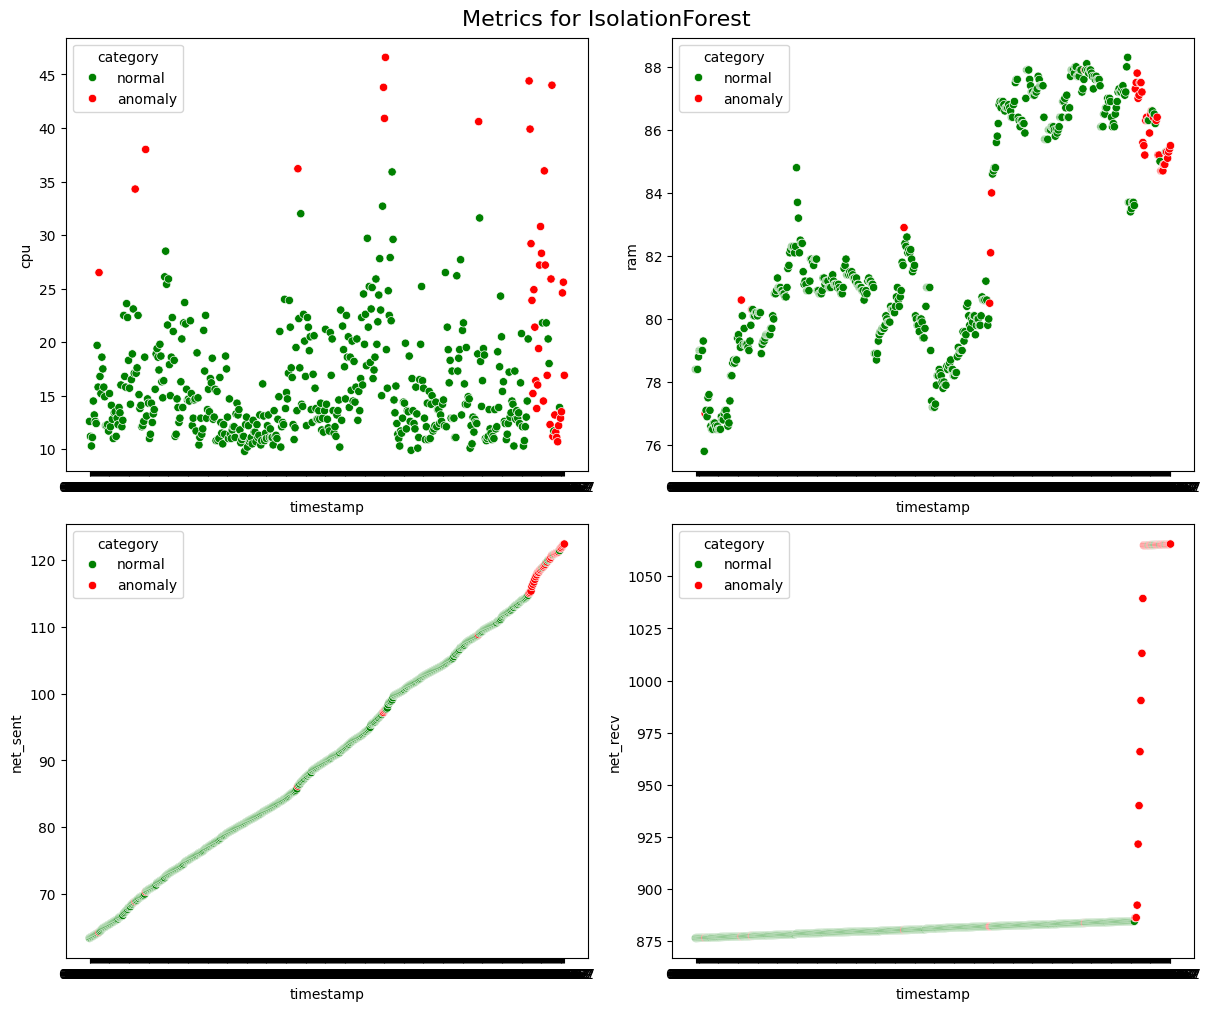

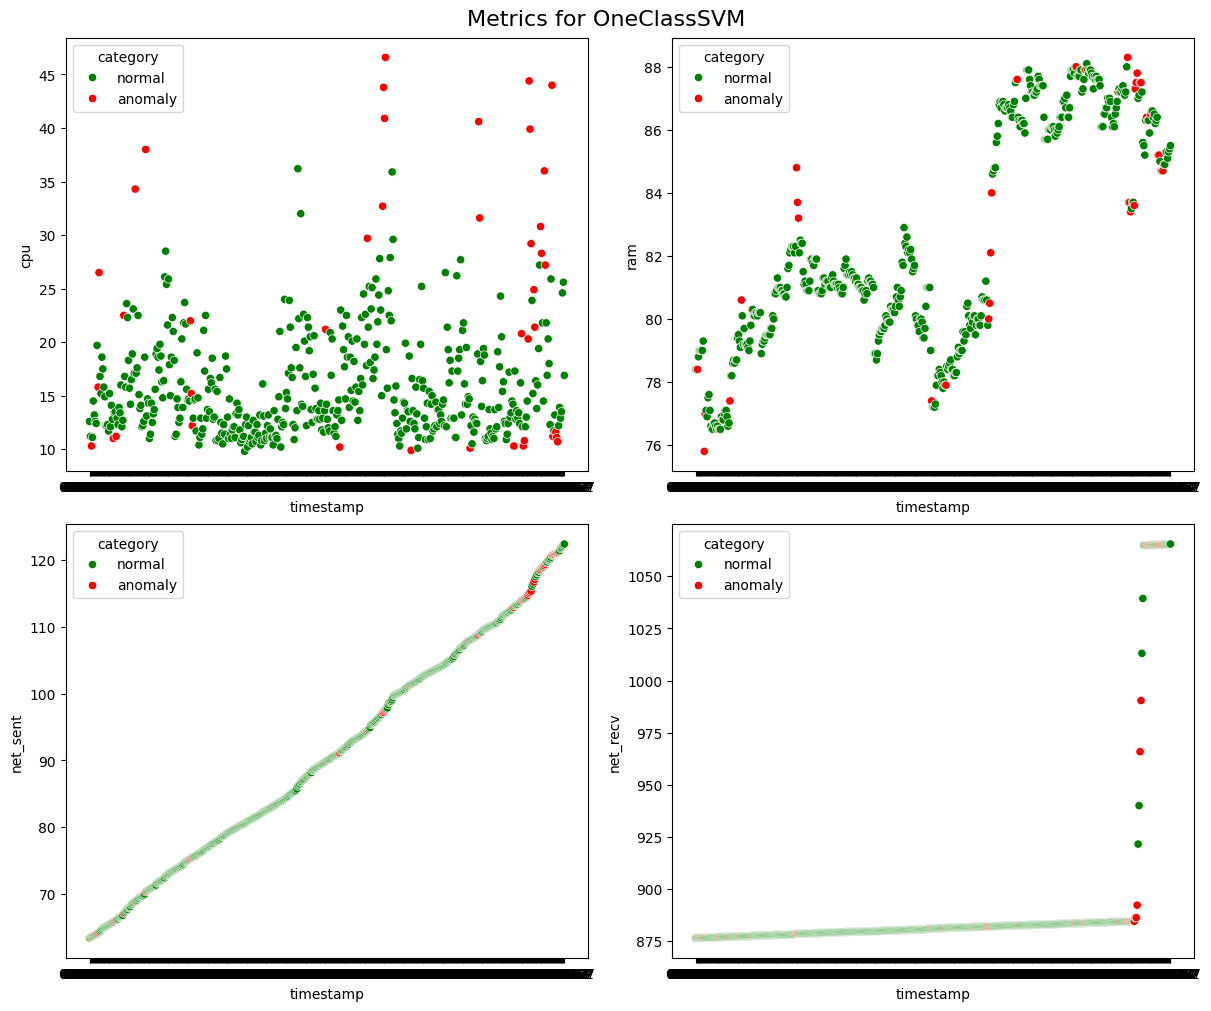

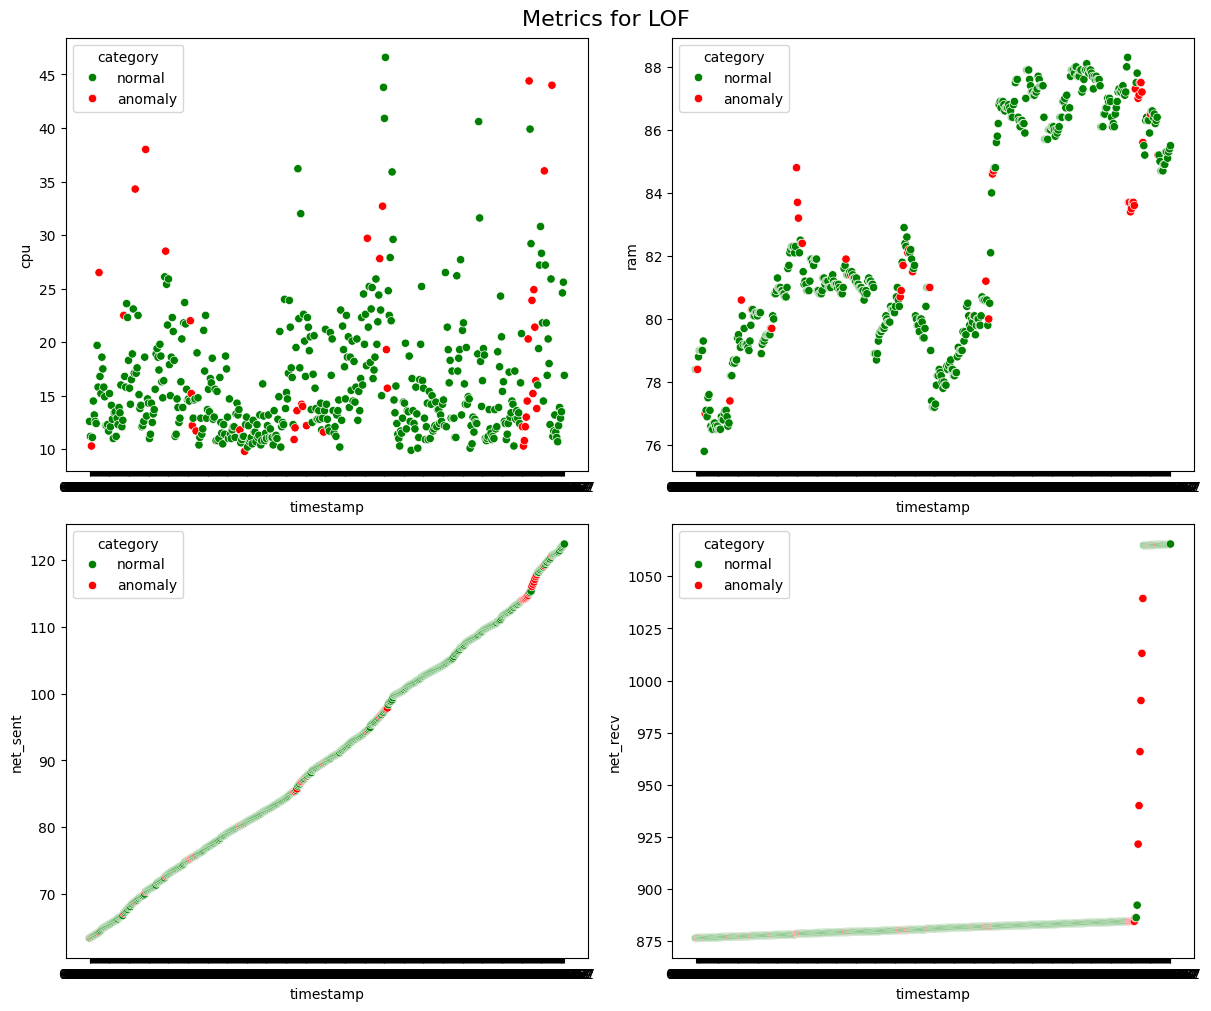

IsolationForest → Detected 45 anomalies out of 500
OneClassSVM → Detected 44 anomalies out of 500
LOF → Detected 45 anomalies out of 500
======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===============IsolationForest===============
-------------------normal--------------------
              cpu         ram    net_sent     net_recv
count  455.000000  455.000000  455.000000   455.000000
mean    15.413846   82.190769   88.698753   881.060307
std      4.456180    3.477676   14.930306     8.968560
min      9.800000  

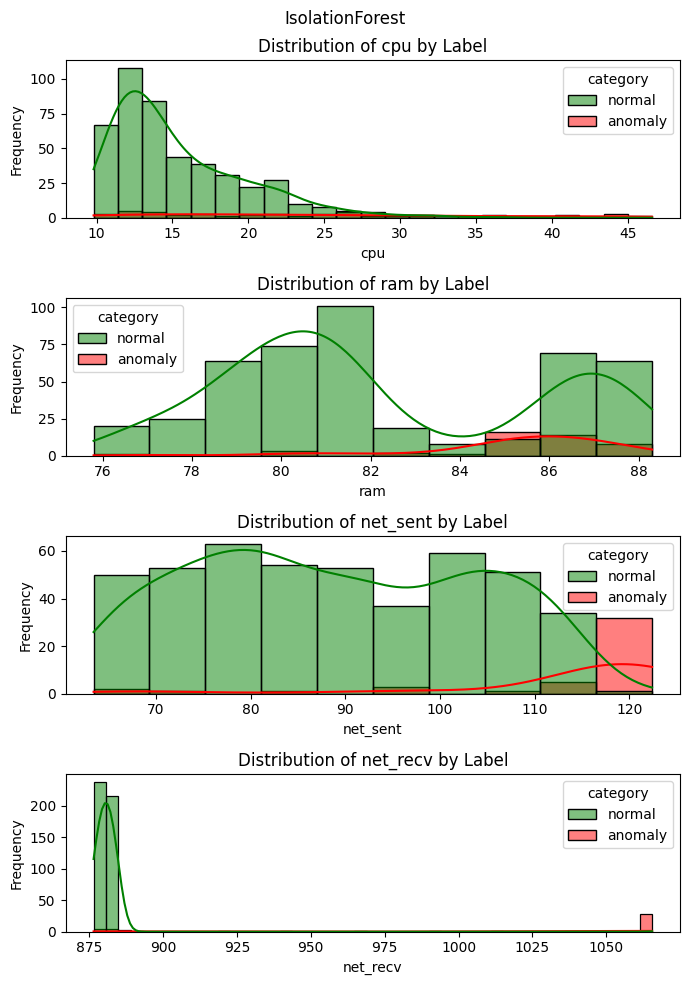

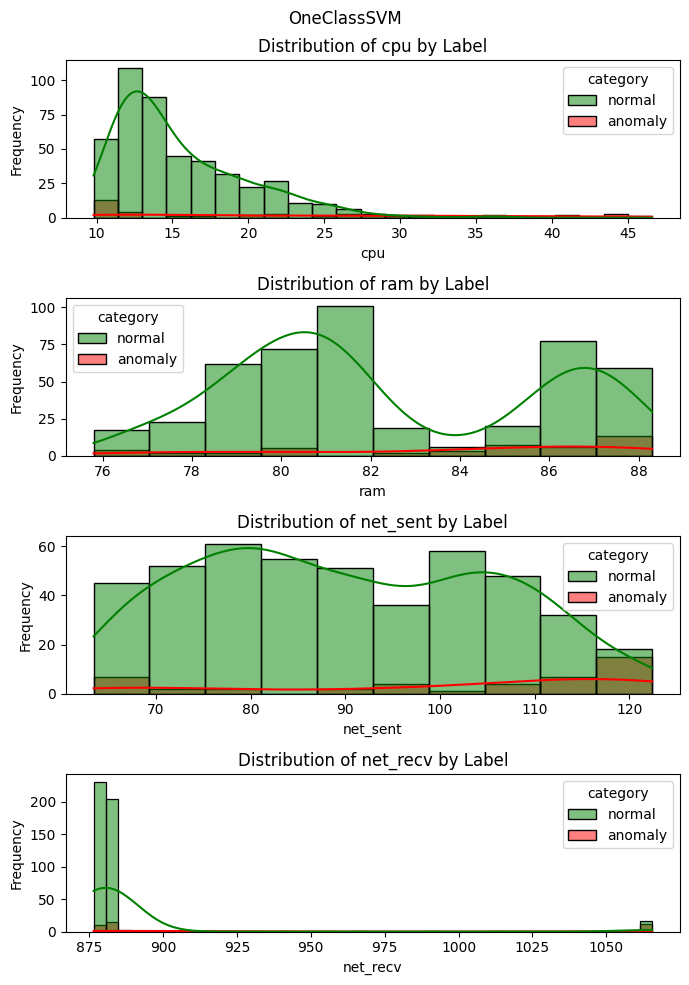

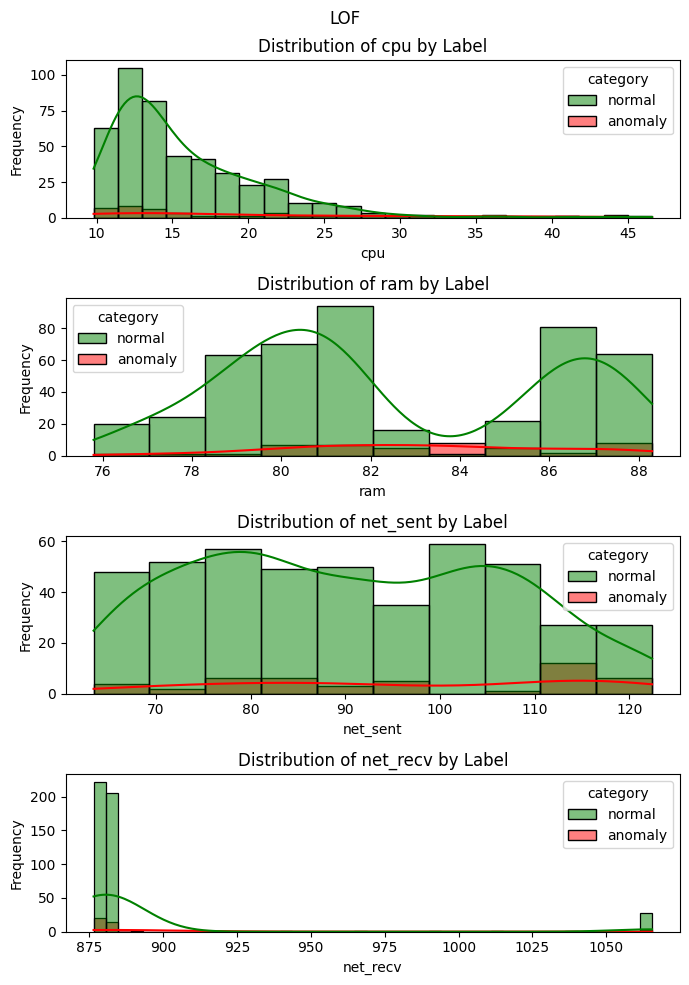

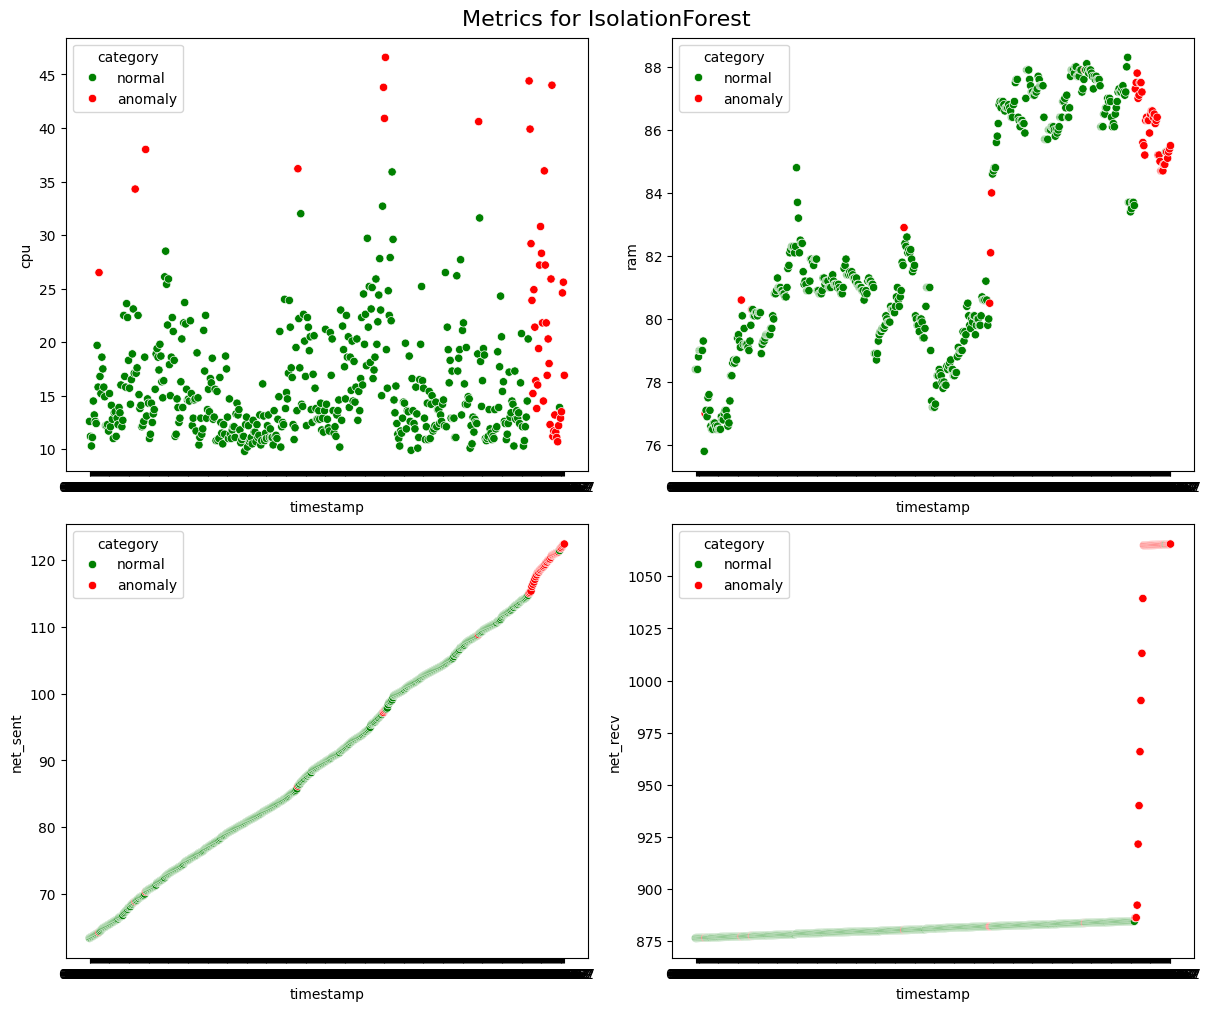

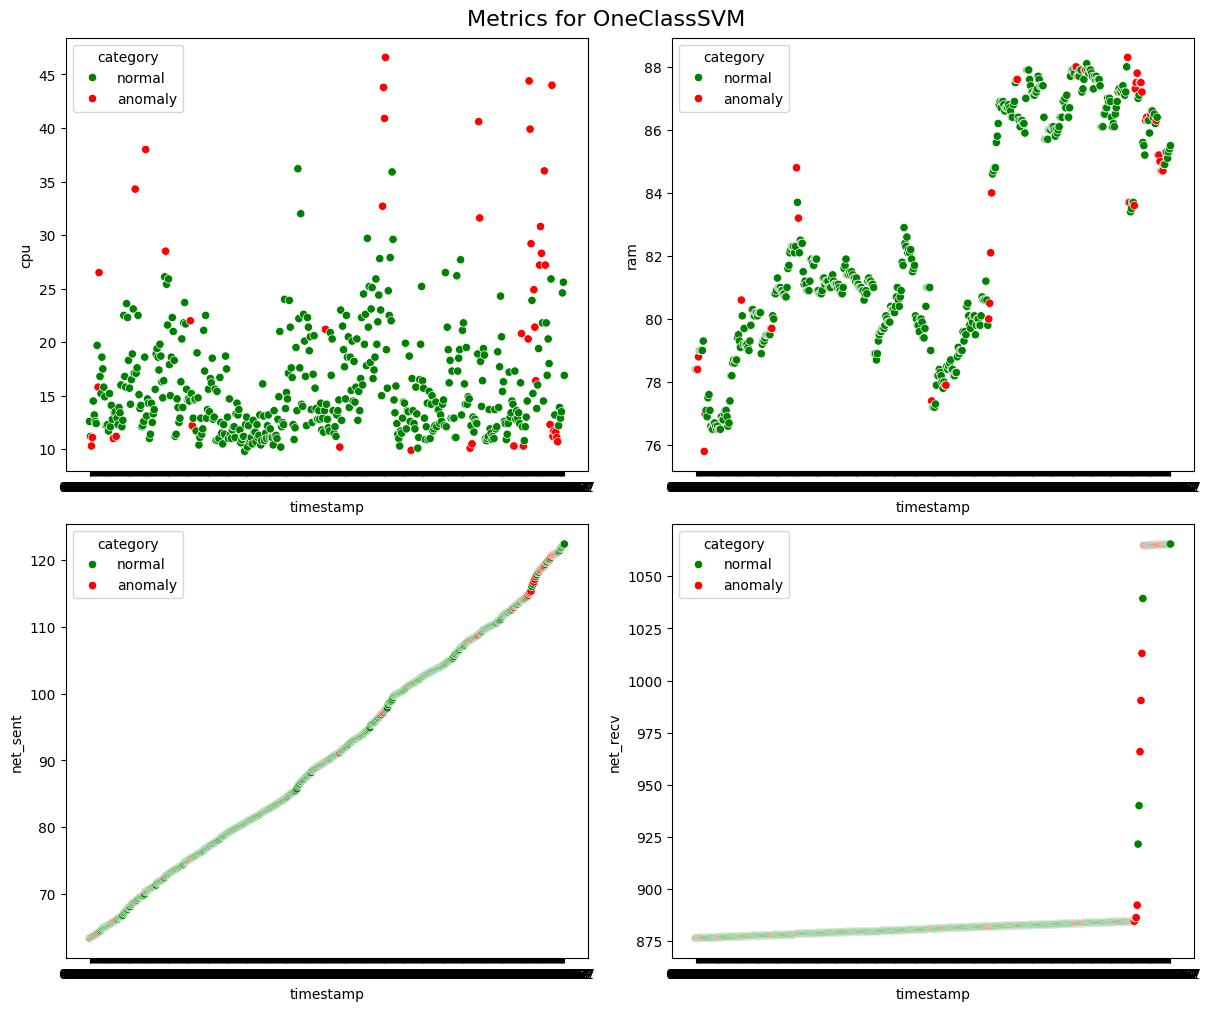

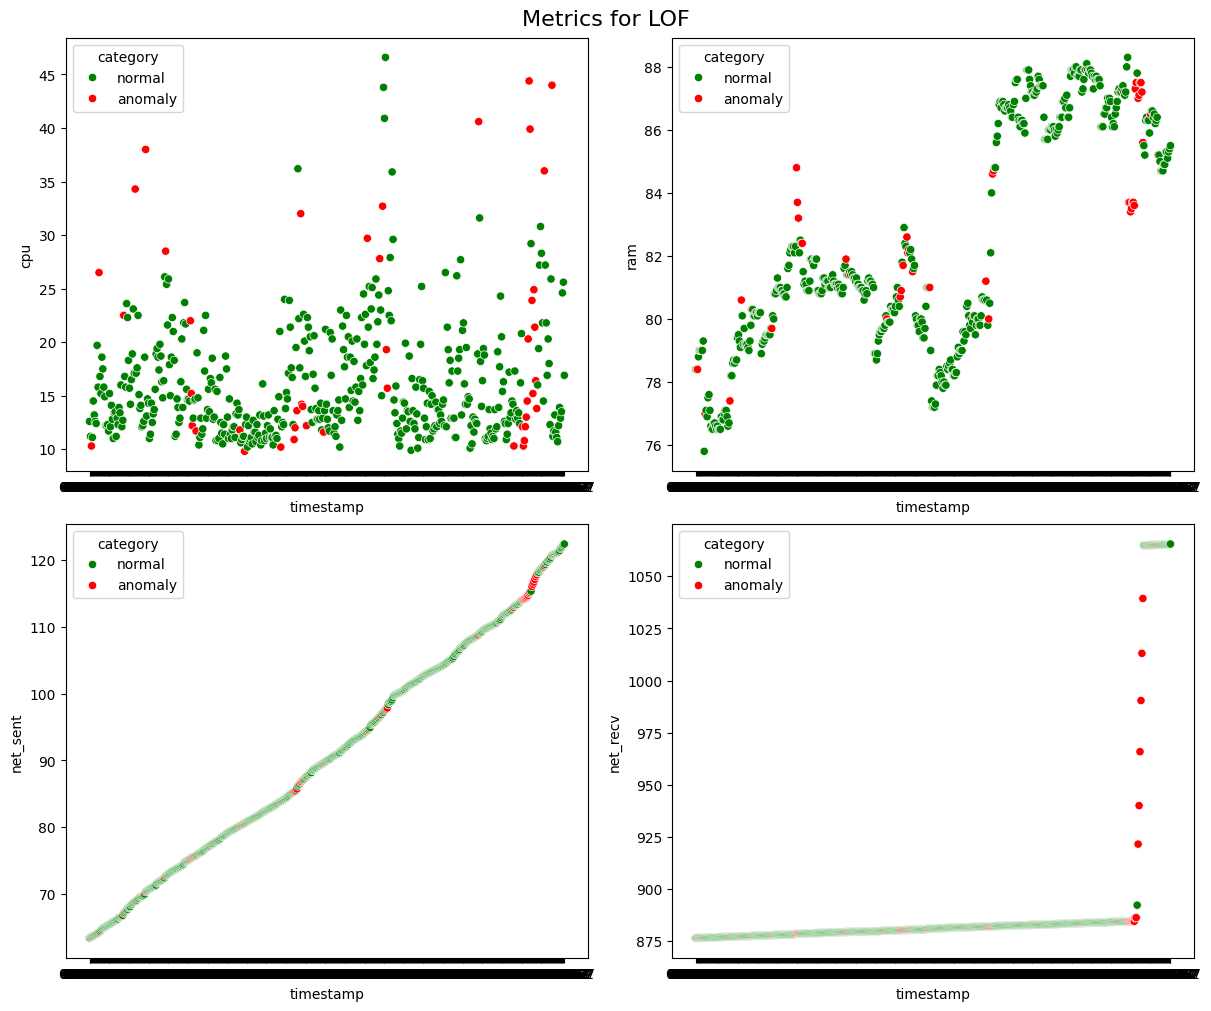

IsolationForest → Detected 50 anomalies out of 500
OneClassSVM → Detected 47 anomalies out of 500
LOF → Detected 50 anomalies out of 500
======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===============IsolationForest===============
-------------------normal--------------------
              cpu         ram    net_sent    net_recv
count  450.000000  450.000000  450.000000  450.000000
mean    15.428222   82.200000   88.621902  880.655284
std      4.461319    3.474886   14.741197    2.340774
min      9.800000   76.

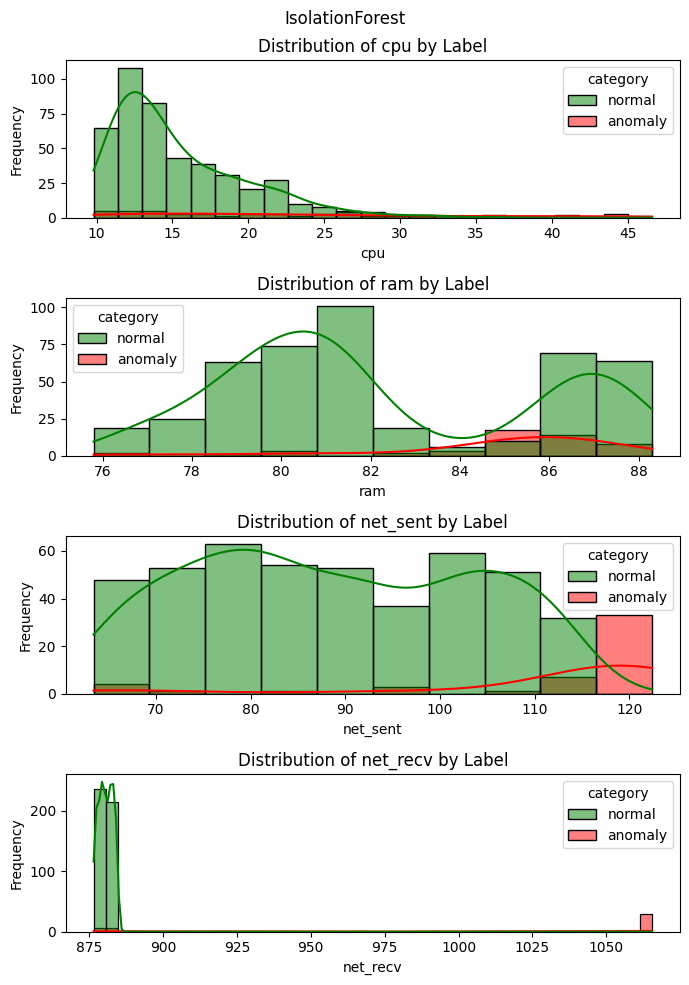

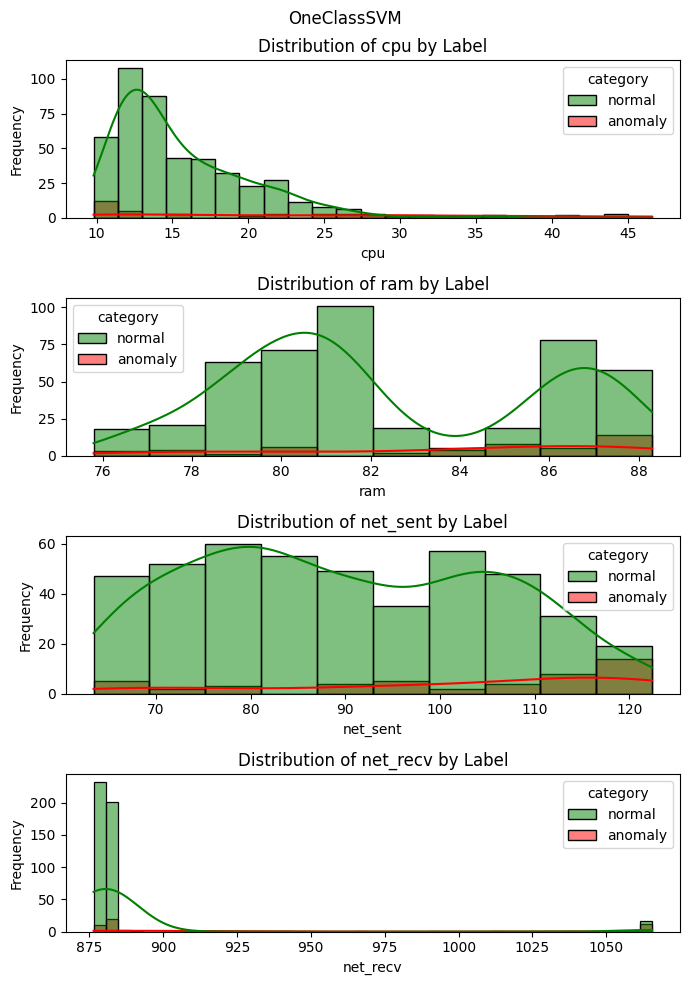

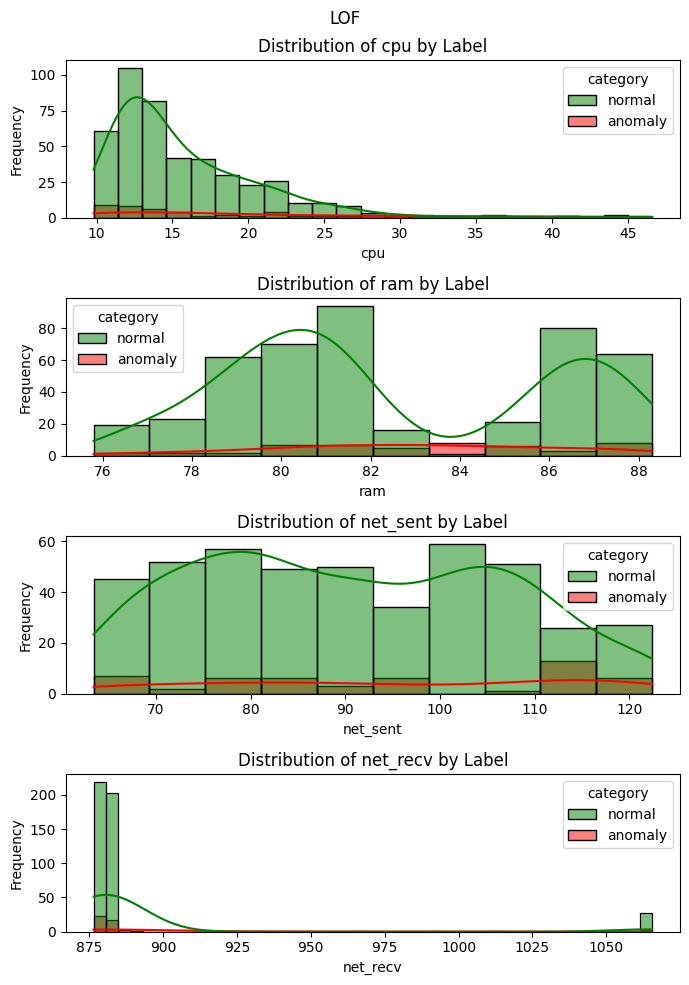

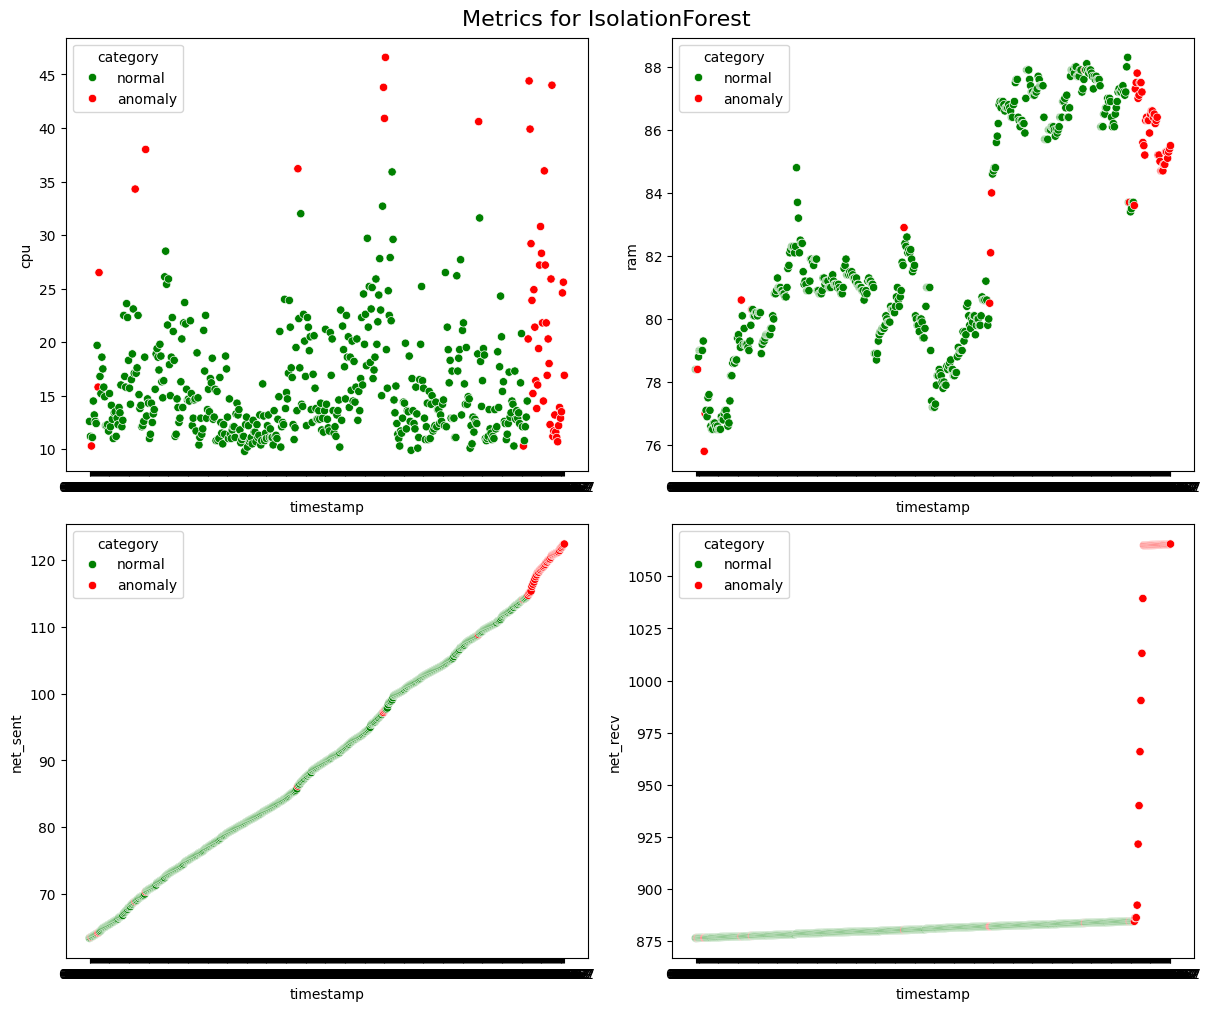

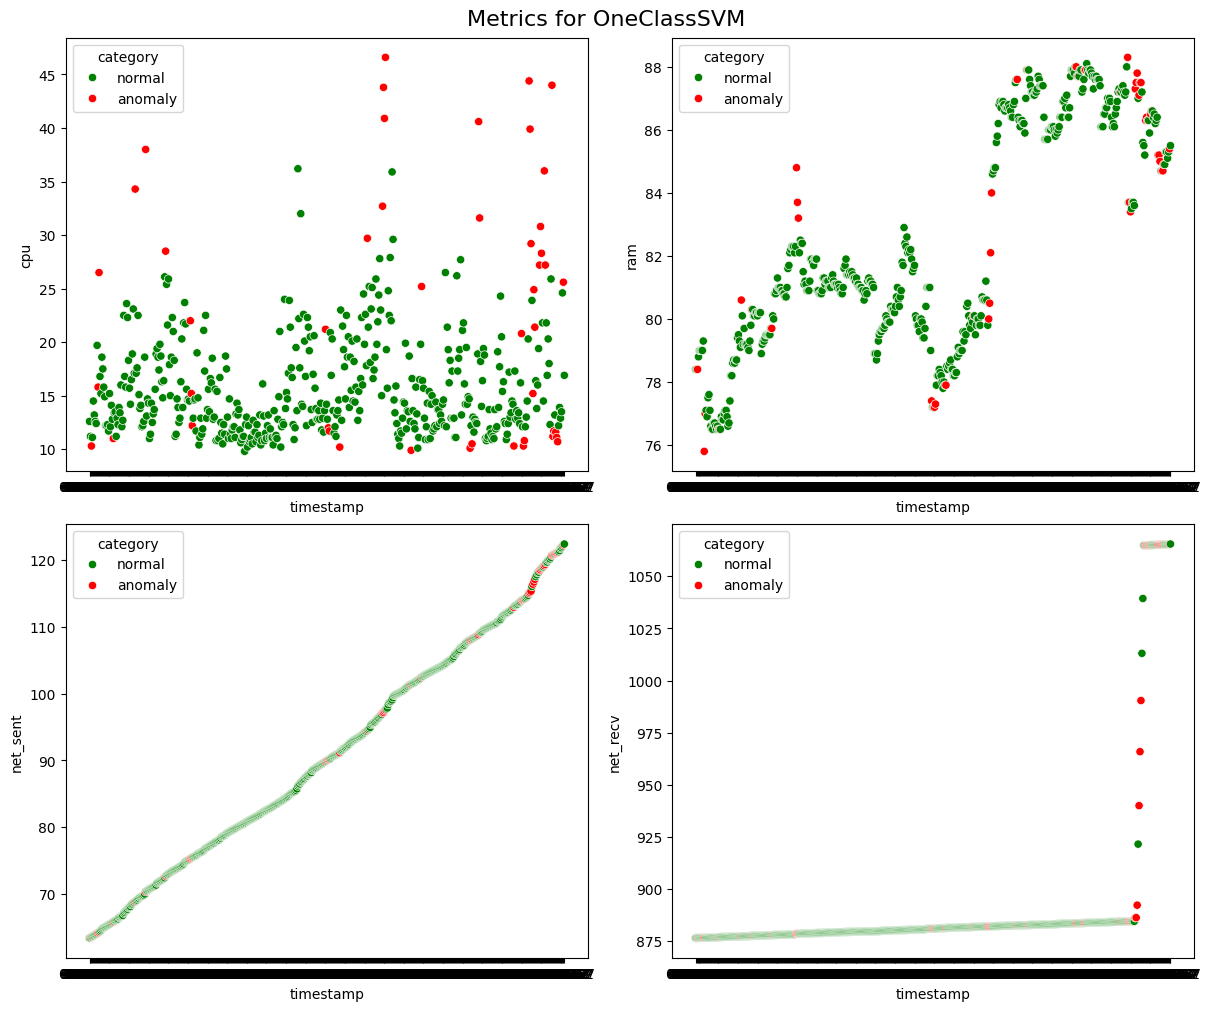

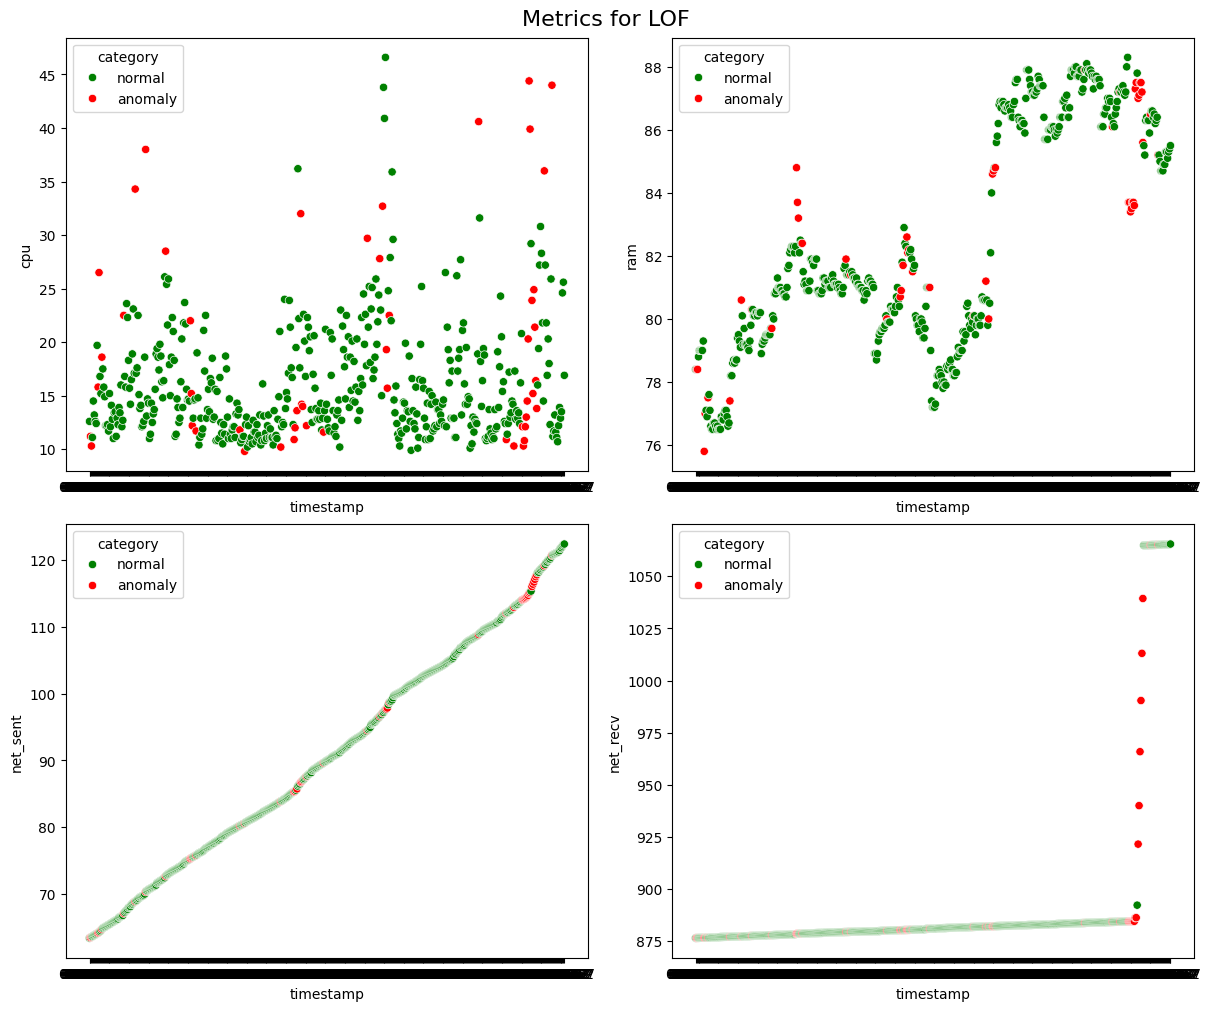

IsolationForest → Detected 55 anomalies out of 500
OneClassSVM → Detected 55 anomalies out of 500
LOF → Detected 55 anomalies out of 500
======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===============IsolationForest===============
-------------------normal--------------------
              cpu         ram    net_sent    net_recv
count  445.000000  445.000000  445.000000  445.000000
mean    15.393708   82.204719   88.588035  880.651250
std      4.353885    3.476102   14.631430    2.324271
min      9.800000   76.

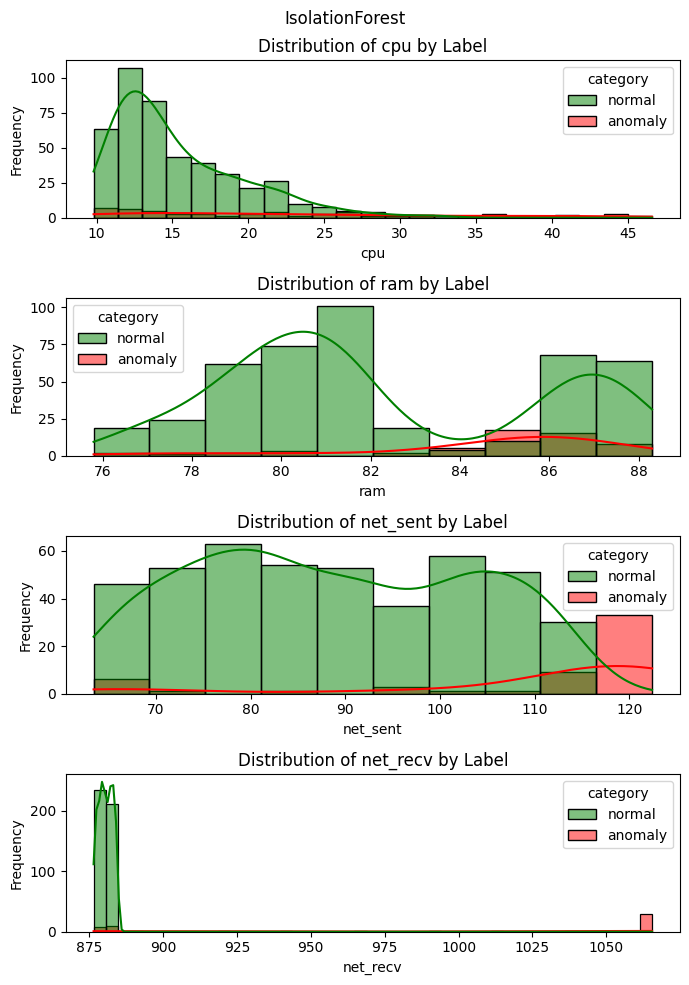

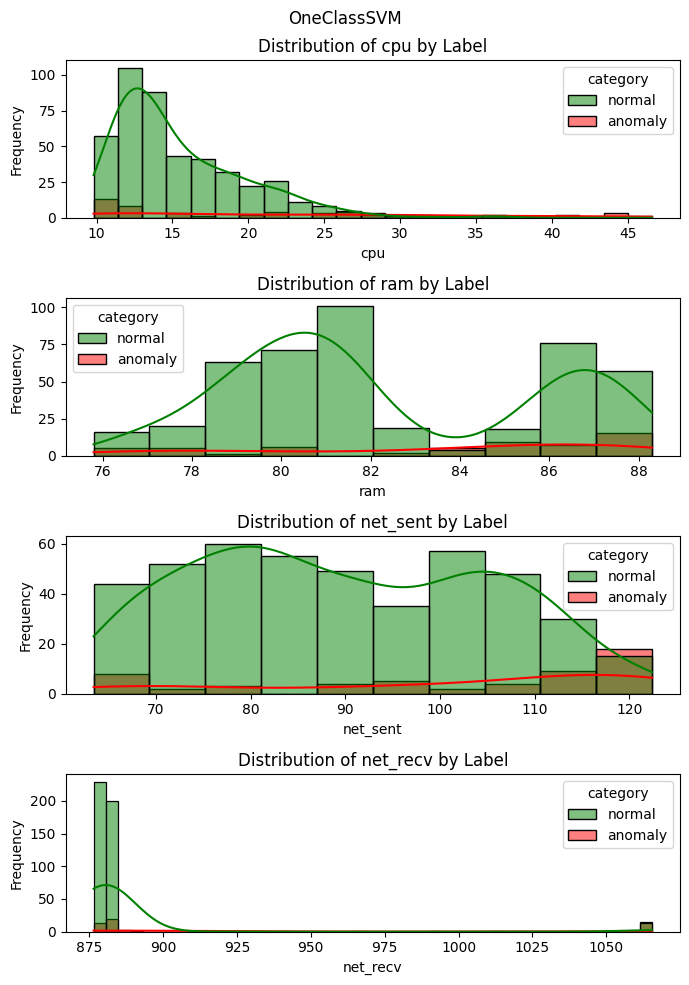

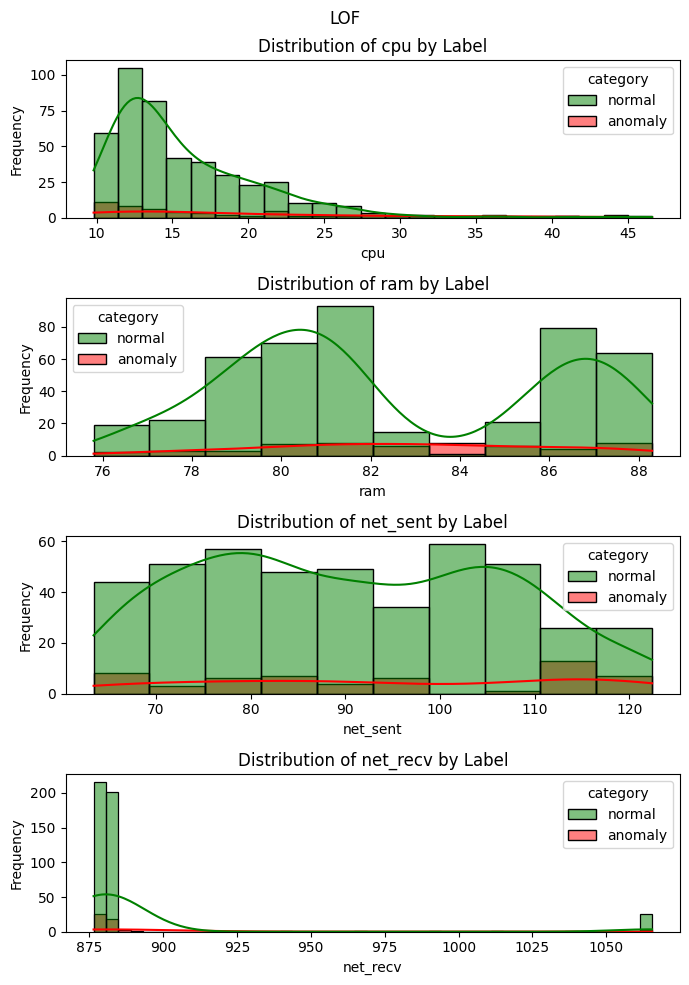

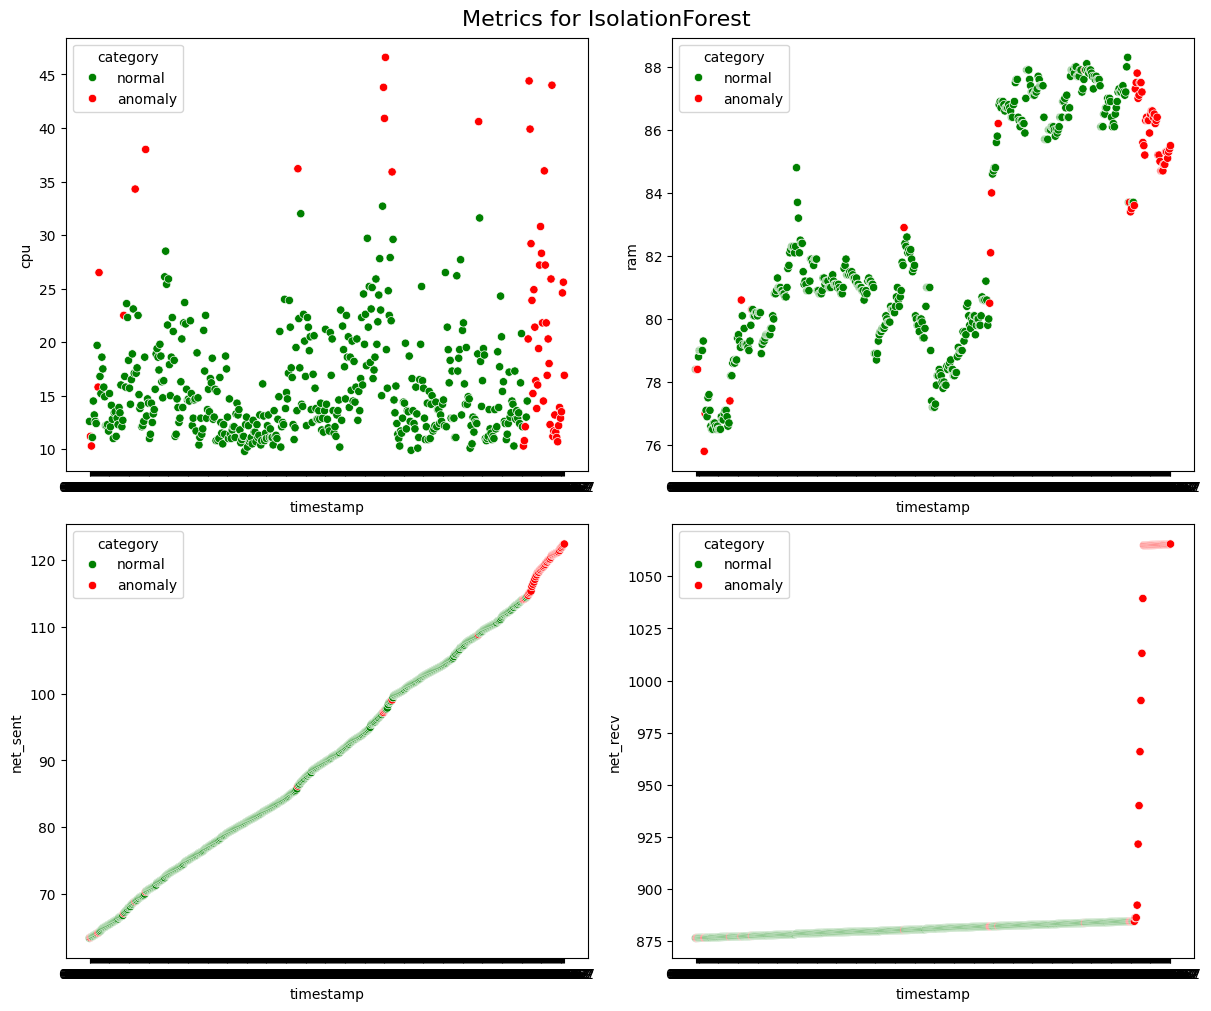

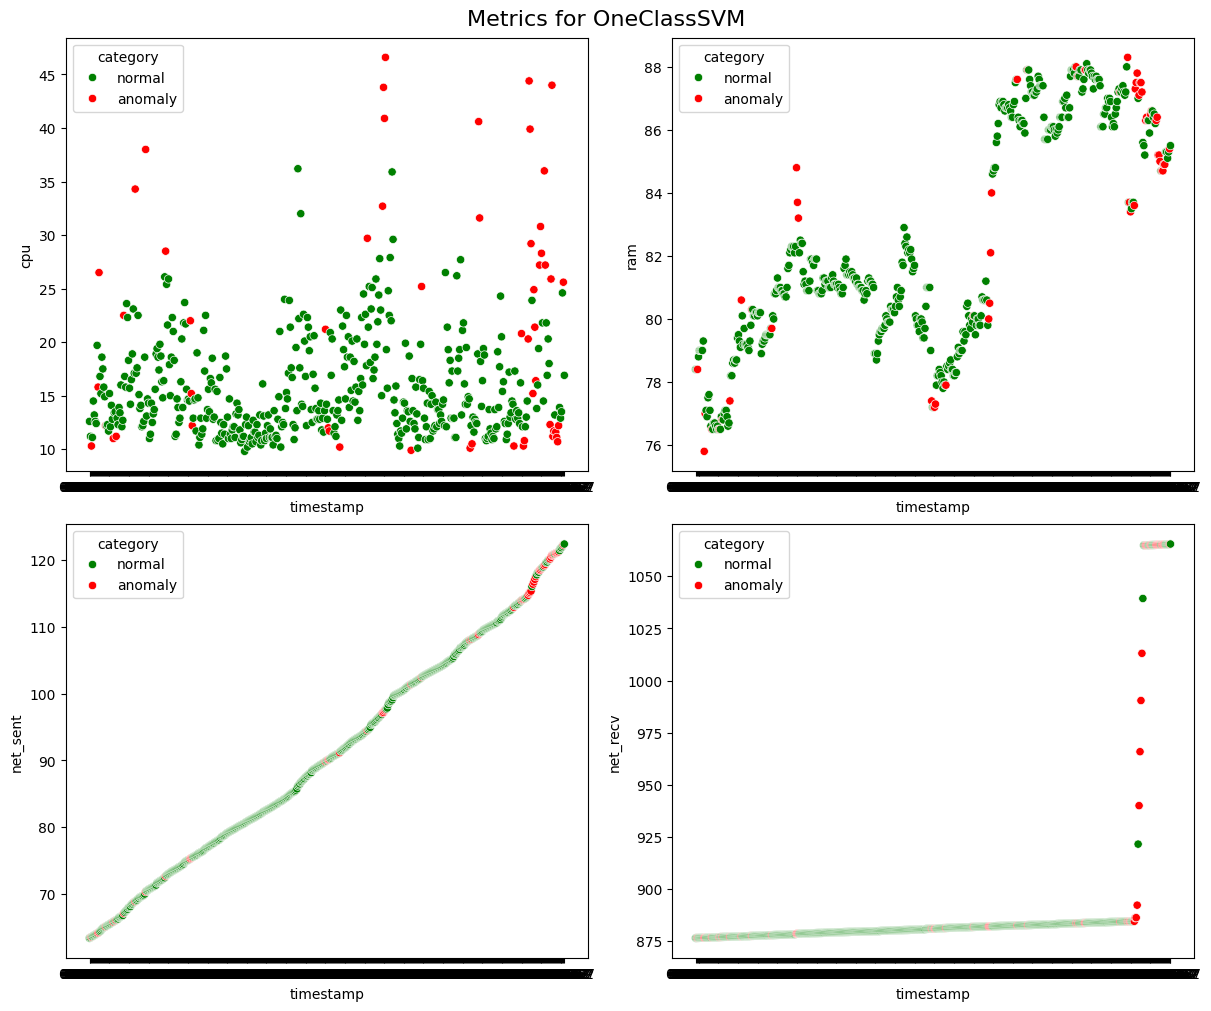

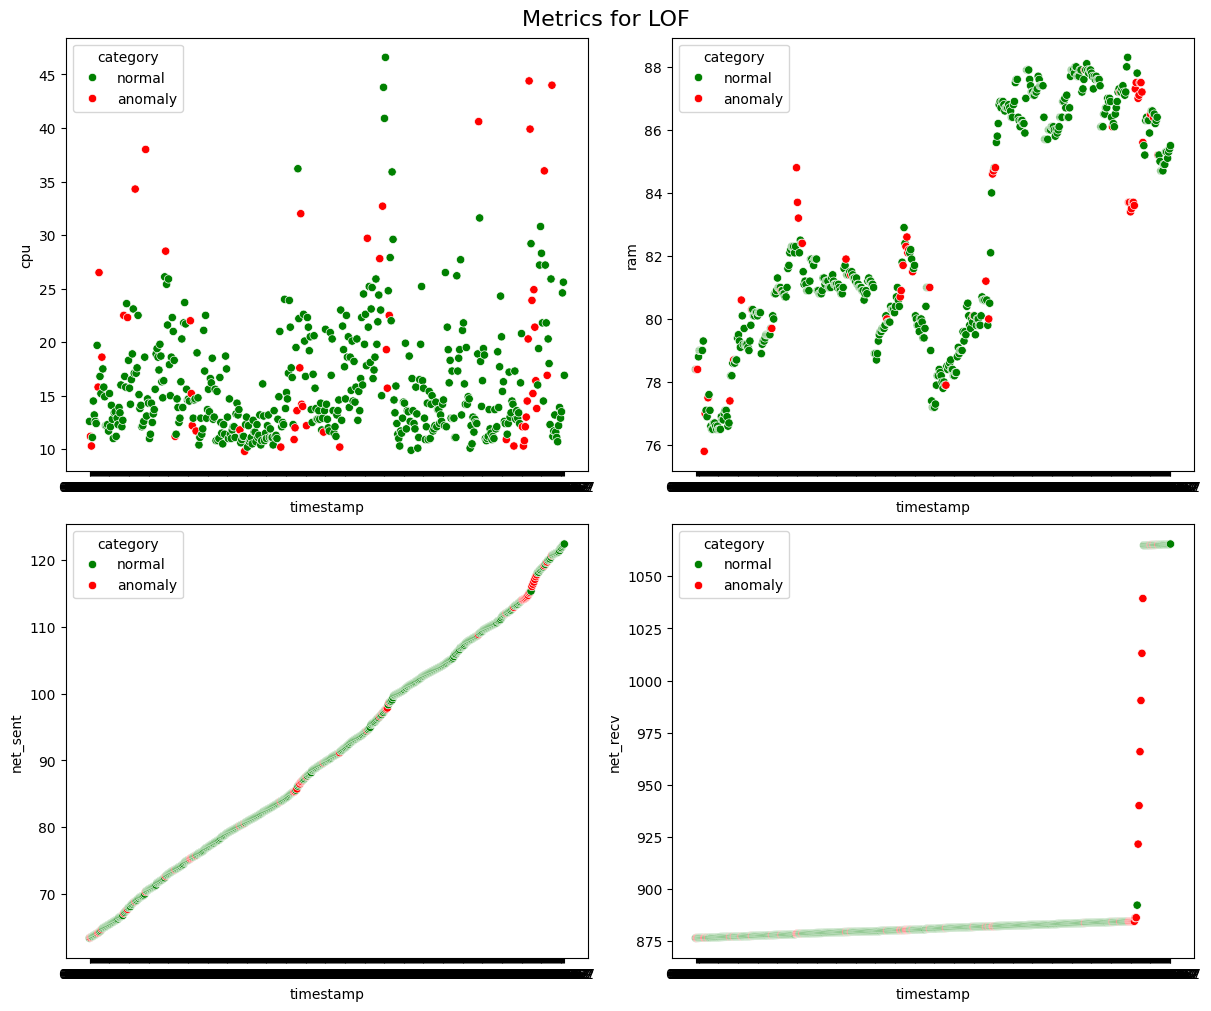

In [38]:
for contamination in np.arange(0.05, 0.12, 0.01):
    # Define models
    models = {
        "IsolationForest": IsolationForest(contamination=contamination, random_state=42),
        "OneClassSVM": OneClassSVM(kernel="rbf", nu=contamination, gamma="scale"),
        "LOF": LocalOutlierFactor(n_neighbors=10, contamination=contamination)
    }
    results = {}

    # Train & Predict anomalies
    for name, model in models.items():
        if name == "LOF":  # LOF has no separate fit/predict
            preds = model.fit_predict(X_scaled)
        else:
            model.fit(X_scaled)
            preds = model.predict(X_scaled)

        preds = np.where(preds == -1, 1, 0)  # 1 = anomaly, 0 = normal
        results[name] = {"model": model, "preds": preds}
        print(f"{name} → Detected {sum(preds)} anomalies out of {len(preds)}")

    def model_evaluation_on_data(model, cat_1="cat_1", cat_2="cat_2"):
        global X
        labels_final = model["preds"]
        name_categories = lambda label: {0: cat_1, 1: cat_2}.get(label, 0)
        result_data = pd.concat([X, pd.Series(labels_final, name="category")], axis=1)
        result_data["category"] = result_data["category"].apply(name_categories)
        print(f"{'-'*15}{cat_1:-^15}{'-'*15}")
        print(result_data.loc[result_data["category"] == cat_1].describe())
        print(f"{'-'*15}{cat_2:-^15}{'-'*15}")
        print(result_data.loc[result_data["category"] == cat_2].describe())
        return result_data

    print(f"{'='*15}{'X':=^15}{'='*15}", X.describe(), sep='\n')

    result_data_all = []
    for model_name, model in results.items():
        print(f"{'='*15}{model_name:=^15}{'='*15}")
        result_data_all.append({"model_name": model_name, "evaluation_data": model_evaluation_on_data(model, cat_1="normal", cat_2="anomaly")})

    for model_result in result_data_all:
        numerical_cols = model_result["evaluation_data"].select_dtypes(include=np.number).columns

        plt.figure(figsize=(7, 10))
        for i, col in enumerate(numerical_cols):
            plt.subplot(len(numerical_cols), 1, i + 1)
            sns.histplot(data=model_result["evaluation_data"], x=col, hue='category', palette={'anomaly': 'red', 'normal': 'green'}, kde=True) # Use hue for coloring by label and palette to set specific colors
            plt.title(f'Distribution of {col} by Label')
            plt.tight_layout()
            plt.xlabel(col)
            plt.suptitle(f"{model_result["model_name"]}")
            plt.ylabel('Frequency' if df[col].dtype != 'object' else 'Count')
            
    for model_result in result_data_all:
        fig = plt.figure(figsize=(12, 10), constrained_layout=True)
        gs = gridspec.GridSpec(2, 2, figure=fig) # Define a 2x2 grid for the current figure
        fig.suptitle(f'Metrics for {model_result["model_name"]}', fontsize=16)
        ax_list = [fig.add_subplot(gs[i, j]) for i in range (2) for j in range (2)]
        for ax, metric in zip(ax_list, X.columns):
            sns.scatterplot(x=df["timestamp"], y=df[metric], hue=model_result["evaluation_data"]["category"], palette={'anomaly': 'red', 'normal': 'green'}, data=df, ax=ax)
        plt.show()